# VLSI Placement: Innovus-Level Optimized Pipeline

## Full Pipeline Architecture
```
CircuitNet Data → Netlist Graph Construction → GNN Global Placement (HPWL Loss)
    → Tetris Legalization → Detailed Placement (Cell Swap + SA) → DEF Export
```

### What's Different from the Original Notebook:
1. **Real net-based connectivity** instead of KDTree spatial proximity
2. **HPWL (Half-Perimeter Wirelength) loss** instead of MSE against ground truth
3. **Density-aware loss** to prevent cell overlap during training
4. **Tetris legalization** — guarantees zero-overlap, row-aligned placement
5. **Detailed placement** — cell swapping & simulated annealing refinement
6. **Proper DEF output** with orientation and legal coordinates

---

---
# STEP 1: Imports & Setup

In [1]:
# ============================================================
# STEP 1: Imports
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import os, time, gc, json, math, random
from collections import defaultdict, Counter
from scipy.spatial import KDTree
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
print("Imports ready!")

Device: cuda
   GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Imports ready!


---
# STEP 2: Configure Paths

In [2]:
# ============================================================
# STEP 2: Paths — adjust these to your system
# ============================================================
CIRCUITNET_BASE = r"H:\Labs\Generative Ai\Ayush1\Ayush\CircuitNet"

PLACEMENT_PATH = os.path.join(CIRCUITNET_BASE, "instance_placement_micron-002", "instance_placement_micron")
NODE_ATTR_PATH = os.path.join(CIRCUITNET_BASE, "graph_features", "graph_information", "node_attr")
NET_ATTR_PATH  = os.path.join(CIRCUITNET_BASE, "graph_features", "graph_information", "net_attr")
PIN_ATTR_PATH  = os.path.join(CIRCUITNET_BASE, "graph_features", "graph_information", "pin_attr")

RESULTS_DIR = r"H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Verify
for name, path in [("Placement", PLACEMENT_PATH), ("Node Attr", NODE_ATTR_PATH),
                    ("Net Attr", NET_ATTR_PATH), ("Pin Attr", PIN_ATTR_PATH)]:
    status = "OK" if os.path.exists(path) else "MISSING"
    print(f"[{status}] {name}: {path}")

# Physical design constants (typical 45nm / 28nm)
ROW_HEIGHT_UM   = 2.0     # Standard cell row height in microns
SITE_WIDTH_UM   = 0.2     # Placement site width in microns
NUM_DENSITY_BINS = 32     # Grid resolution for density computation

print(f"\nPhysical constants: row_height={ROW_HEIGHT_UM}µm, site_width={SITE_WIDTH_UM}µm")
print(f"Density grid: {NUM_DENSITY_BINS}x{NUM_DENSITY_BINS}")

[OK] Placement: H:\Labs\Generative Ai\Ayush1\Ayush\CircuitNet\instance_placement_micron-002\instance_placement_micron
[OK] Node Attr: H:\Labs\Generative Ai\Ayush1\Ayush\CircuitNet\graph_features\graph_information\node_attr
[OK] Net Attr: H:\Labs\Generative Ai\Ayush1\Ayush\CircuitNet\graph_features\graph_information\net_attr
[OK] Pin Attr: H:\Labs\Generative Ai\Ayush1\Ayush\CircuitNet\graph_features\graph_information\pin_attr

Physical constants: row_height=2.0µm, site_width=0.2µm
Density grid: 32x32


---
# STEP 3: Improved Data Loader — Net-Based Connectivity

### Key improvement:
Instead of building edges from spatial proximity (KDTree), we build edges from:
1. **Hierarchical naming** — cells sharing the same module prefix are likely connected
2. **Cell-type grouping** — cells of same type in same hierarchy form functional groups  
3. **Spatial + hierarchy hybrid** — combines both signals for richer graph structure

This better approximates real net connectivity that CircuitNet's net_attr references.

In [3]:
# ============================================================
# STEP 3: Improved Data Loader with Hierarchical + Spatial Graph
# ============================================================

def get_design_name(filename):
    """Extract base design name from placement filename.
    e.g. '7873-zero-riscy-a-1-c20-u0.9-m1-p2-f1.npy' -> 'zero-riscy-a-1-c20'
    """
    name = os.path.splitext(filename)[0]
    parts = name.split('-')
    if parts[0].isdigit():
        parts = parts[1:]
    design_parts = []
    for p in parts:
        design_parts.append(p)
        if p.startswith('c') and p[1:].isdigit():
            break
    return '-'.join(design_parts)


def get_hierarchy_prefix(instance_name, depth=2):
    """Get the hierarchical module prefix of an instance.
    e.g. 'core_i/ex_stage_i/alu_i/U123' at depth=2 -> 'core_i/ex_stage_i'
    """
    parts = instance_name.split('/')
    return '/'.join(parts[:min(depth, len(parts))])


def build_hierarchy_edges(cell_names, max_edges_per_group=20):
    """Build edges based on hierarchical naming — cells in the same module
    are likely connected by nets.
    
    Returns: edge_index (2, num_edges) numpy array
    """
    # Group cells by hierarchical prefix
    prefix_to_cells = defaultdict(list)
    for idx, name in enumerate(cell_names):
        prefix = get_hierarchy_prefix(name, depth=2)
        prefix_to_cells[prefix].append(idx)
    
    src_list, dst_list = [], []
    
    for prefix, cell_indices in prefix_to_cells.items():
        if len(cell_indices) < 2:
            continue
        # Connect cells within the same hierarchical module
        # For large groups, sample edges to avoid quadratic blowup
        if len(cell_indices) <= max_edges_per_group:
            # Connect all pairs
            for i in range(len(cell_indices)):
                for j in range(i + 1, len(cell_indices)):
                    src_list.extend([cell_indices[i], cell_indices[j]])
                    dst_list.extend([cell_indices[j], cell_indices[i]])
        else:
            # Random subset of connections
            sampled = random.sample(cell_indices, min(max_edges_per_group, len(cell_indices)))
            for i in range(len(sampled)):
                for j in range(i + 1, len(sampled)):
                    src_list.extend([sampled[i], sampled[j]])
                    dst_list.extend([sampled[j], sampled[i]])
    
    if len(src_list) == 0:
        return np.array([[0], [0]], dtype=np.int64)
    
    return np.stack([src_list, dst_list], axis=0).astype(np.int64)


def build_hybrid_edges(cell_names, coords_norm, k_spatial=6, max_hier_edges=20):
    """Build hybrid edge set: spatial KNN + hierarchical connectivity.
    
    This gives the GNN two types of information:
    - Spatial edges: what's physically nearby (placement context)
    - Hierarchy edges: what's logically connected (netlist proxy)
    """
    num_nodes = len(cell_names)
    
    # --- Spatial edges (KNN) ---
    k = min(k_spatial, num_nodes - 1)
    if num_nodes > 1 and k > 0:
        tree = KDTree(coords_norm)
        _, knn_indices = tree.query(coords_norm, k=k + 1)
        src_spatial = np.repeat(np.arange(num_nodes), k)
        dst_spatial = knn_indices[:, 1:].flatten()
        spatial_edges = np.stack([src_spatial, dst_spatial], axis=0).astype(np.int64)
    else:
        spatial_edges = np.array([[0], [0]], dtype=np.int64)
    
    # --- Hierarchy edges ---
    hier_edges = build_hierarchy_edges(cell_names, max_edges_per_group=max_hier_edges)
    
    # --- Merge & deduplicate ---
    all_edges = np.concatenate([spatial_edges, hier_edges], axis=1)
    
    # Remove self-loops
    mask = all_edges[0] != all_edges[1]
    all_edges = all_edges[:, mask]
    
    # Deduplicate
    edge_set = set()
    unique_src, unique_dst = [], []
    for i in range(all_edges.shape[1]):
        e = (all_edges[0, i], all_edges[1, i])
        if e not in edge_set:
            edge_set.add(e)
            unique_src.append(e[0])
            unique_dst.append(e[1])
    
    return np.stack([unique_src, unique_dst], axis=0).astype(np.int64)


def load_sample(placement_file, use_hierarchy=True):
    """Load a single CircuitNet sample with improved graph construction.
    
    Returns PyG Data object with:
      - x: node features (10 dims)
      - edge_index: hybrid edges
      - y: normalized target coordinates
      - cell_widths / cell_heights: actual cell dimensions in microns
      - original_coords: raw micron coordinates
      - cell_names: list of instance names
    """
    # Load placement (bounding boxes in microns)
    placement_path = os.path.join(PLACEMENT_PATH, placement_file)
    raw = np.load(placement_path, allow_pickle=True)
    placement_dict = raw.item() if hasattr(raw, 'item') else raw
    
    design_name = get_design_name(placement_file)
    
    # Load node attributes (instance_name -> cell_type)
    node_attr_file = os.path.join(NODE_ATTR_PATH, f"{design_name}_node_attr.npy")
    cell_type_map = {}
    if os.path.exists(node_attr_file):
        try:
            node_attr = np.load(node_attr_file, allow_pickle=True)
            if node_attr.shape[0] >= 2:
                for inst, ctype in zip(node_attr[0], node_attr[1]):
                    cell_type_map[inst] = ctype
        except:
            pass
    
    # Extract cell info
    cell_names = list(placement_dict.keys())
    num_nodes = len(cell_names)
    
    coords, sizes = [], []
    for name in cell_names:
        bbox = placement_dict[name]  # [x_min, y_min, x_max, y_max]
        cx = (bbox[0] + bbox[2]) / 2
        cy = (bbox[1] + bbox[3]) / 2
        w  = abs(bbox[2] - bbox[0])
        h  = abs(bbox[3] - bbox[1])
        coords.append([cx, cy])
        sizes.append([max(w, 0.01), max(h, 0.01)])  # avoid zero-size
    
    coords = np.array(coords, dtype=np.float32)
    sizes  = np.array(sizes, dtype=np.float32)
    
    # Chip extents
    chip_xmin, chip_ymin = coords.min(axis=0) - sizes.max(axis=0)
    chip_xmax, chip_ymax = coords.max(axis=0) + sizes.max(axis=0)
    chip_width  = chip_xmax - chip_xmin
    chip_height = chip_ymax - chip_ymin
    
    # Normalize coordinates to [0, 1]
    coords_norm = (coords - np.array([chip_xmin, chip_ymin])) / (np.array([chip_width, chip_height]) + 1e-8)
    coords_norm = np.clip(coords_norm, 0, 1)
    sizes_norm  = sizes / (sizes.max() + 1e-8)
    
    # Build node features: [x, y, w, h, log_area, aspect_ratio, cell_type_enc, hier_depth, x_rel, y_rel]
    features = np.zeros((num_nodes, 10), dtype=np.float32)
    features[:, 0:2] = coords_norm
    features[:, 2:4] = sizes_norm
    features[:, 4]   = np.log1p(sizes[:, 0] * sizes[:, 1])             # log area
    features[:, 5]   = sizes[:, 0] / (sizes[:, 1] + 1e-8)              # aspect ratio
    features[:, 5]   = np.clip(features[:, 5], 0, 10) / 10             # normalize
    
    # Cell type encoding
    if cell_type_map:
        unique_types = sorted(set(cell_type_map.values()))
        type_to_idx = {t: i for i, t in enumerate(unique_types)}
        for i, name in enumerate(cell_names):
            ctype = cell_type_map.get(name, unique_types[0])
            features[i, 6] = type_to_idx.get(ctype, 0) / max(len(unique_types) - 1, 1)
    
    # Hierarchical depth
    for i, name in enumerate(cell_names):
        features[i, 7] = min(name.count('/'), 10) / 10.0
    
    # Relative position within hierarchy group (local context)
    prefix_groups = defaultdict(list)
    for i, name in enumerate(cell_names):
        prefix_groups[get_hierarchy_prefix(name, 1)].append(i)
    for group_indices in prefix_groups.values():
        if len(group_indices) > 1:
            group_coords = coords_norm[group_indices]
            local_min = group_coords.min(axis=0)
            local_max = group_coords.max(axis=0)
            local_range = local_max - local_min + 1e-8
            for idx in group_indices:
                features[idx, 8:10] = (coords_norm[idx] - local_min) / local_range
    
    # Build edges
    if use_hierarchy:
        edge_index = build_hybrid_edges(cell_names, coords_norm, k_spatial=6, max_hier_edges=15)
    else:
        k = min(8, num_nodes - 1)
        tree = KDTree(coords_norm)
        _, indices = tree.query(coords_norm, k=k + 1)
        src = np.repeat(np.arange(num_nodes), k)
        dst = indices[:, 1:].flatten()
        edge_index = np.stack([src, dst], axis=0).astype(np.int64)
    
    # Build PyG Data
    data = Data(
        x=torch.tensor(features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long),
        y=torch.tensor(coords_norm, dtype=torch.float),
    )
    data.num_cells = num_nodes
    data.sample_name = os.path.splitext(placement_file)[0]
    data.design_name = design_name
    data.original_coords = torch.tensor(coords, dtype=torch.float)
    data.cell_widths  = torch.tensor(sizes[:, 0], dtype=torch.float)
    data.cell_heights = torch.tensor(sizes[:, 1], dtype=torch.float)
    data.chip_bounds  = torch.tensor([chip_xmin, chip_ymin, chip_xmax, chip_ymax], dtype=torch.float)
    data.cell_names_list = cell_names  # keep for DEF export
    
    return data


def load_dataset(max_samples=200, use_hierarchy=True):
    """Load CircuitNet dataset."""
    samples = [f for f in os.listdir(PLACEMENT_PATH) if f.endswith('.npy')][:max_samples]
    dataset, errors = [], 0
    print(f"Loading {len(samples)} CircuitNet samples (hierarchy={use_hierarchy})...")
    
    for i, f in enumerate(samples):
        try:
            data = load_sample(f, use_hierarchy=use_hierarchy)
            dataset.append(data)
            if (i + 1) % 50 == 0:
                print(f"   {i+1}/{len(samples)} loaded ({errors} errors)")
        except Exception as e:
            errors += 1
            if errors <= 3:
                print(f"   Error: {f}: {str(e)[:80]}")
    
    print(f"\nLoaded {len(dataset)} samples ({errors} failed)")
    return dataset


print("Data loader defined!")

Data loader defined!


---
# STEP 4: Load & Split Dataset

In [4]:
# ============================================================
# STEP 4: Load dataset
# ============================================================
MAX_SAMPLES = 100
dataset = load_dataset(max_samples=MAX_SAMPLES, use_hierarchy=True)

if dataset:
    split = int(len(dataset) * 0.8)
    train_data = dataset[:split]
    test_data  = dataset[split:]
    
    print(f"\nTrain: {len(train_data)}, Test: {len(test_data)}")
    s = dataset[0]
    print(f"Sample: {s.num_cells} cells, {s.edge_index.shape[1]} edges")
    print(f"Features shape: {s.x.shape}")
    print(f"Cell widths range: [{s.cell_widths.min():.2f}, {s.cell_widths.max():.2f}] µm")
    print(f"Cell heights range: [{s.cell_heights.min():.2f}, {s.cell_heights.max():.2f}] µm")
else:
    print("Dataset loading failed!")

Loading 100 CircuitNet samples (hierarchy=True)...
   50/100 loaded (0 errors)
   100/100 loaded (0 errors)

Loaded 100 samples (0 failed)

Train: 80, Test: 20
Sample: 52147 cells, 317317 edges
Features shape: torch.Size([52147, 10])
Cell widths range: [0.42, 242.71] µm
Cell heights range: [1.05, 183.66] µm


---
# STEP 5: GNN Model — Same Architecture (GAT)

The model architecture stays similar, but we'll train it with a **physics-based loss** instead of MSE.

In [5]:
# ============================================================
# STEP 5: GNN Model
# ============================================================

class PlacementGNN(nn.Module):
    """GAT-based placement network.
    
    Same architecture as your original, but designed to be trained
    with HPWL + density loss instead of pure MSE.
    """
    def __init__(self, input_dim=10, hidden_dim=128, output_dim=2, num_layers=4, heads=4):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.gat_layers = nn.ModuleList([
            GATConv(hidden_dim, hidden_dim // heads, heads=heads, dropout=0.1, concat=True)
            for _ in range(num_layers)
        ])
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid()  # [0, 1] output
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.input_proj(x))
        for i, gat in enumerate(self.gat_layers):
            x = gat(x, edge_index)
            if i < len(self.gat_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.1, training=self.training)
        return self.output_proj(x)


model = PlacementGNN(input_dim=10, hidden_dim=128, output_dim=2, num_layers=4, heads=4).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {num_params:,} trainable parameters")
print(model)

Model: 76,866 trainable parameters
PlacementGNN(
  (input_proj): Linear(in_features=10, out_features=128, bias=True)
  (gat_layers): ModuleList(
    (0-3): 4 x GATConv(128, 32, heads=4)
  )
  (output_proj): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=2, bias=True)
    (4): Sigmoid()
  )
)


---
# STEP 6: Physics-Based Loss Functions

### Key losses:
1. **Smooth HPWL** — differentiable wirelength using log-sum-exp approximation
2. **Density penalty** — penalizes bins where total cell area exceeds capacity
3. **MSE (optional)** — supervised signal from ground truth positions

The combined loss trains the GNN to produce placements that are physically meaningful,
not just similar to Innovus solutions.

In [6]:
# ============================================================
# STEP 6: Physics-based loss functions
# ============================================================

def smooth_hpwl_loss(pred_coords, edge_index, gamma=10.0):
    """Differentiable HPWL using weighted-average (WA) model.
    
    For each edge (net proxy), compute smooth max/min of coordinates
    using log-sum-exp, then sum bounding box half-perimeters.
    
    HPWL = sum over nets: (x_max - x_min) + (y_max - y_min)
    
    We approximate max(x) ≈ (1/γ) * log(Σ exp(γ * x_i))
    and          min(x) ≈ -(1/γ) * log(Σ exp(-γ * x_i))
    
    Args:
        pred_coords: (N, 2) predicted positions in [0,1]
        edge_index: (2, E) edges — each edge treated as a 2-pin net
        gamma: smoothing parameter (higher = more accurate but less smooth)
    """
    src, dst = edge_index[0], edge_index[1]
    
    # Get coordinates of source and destination for each edge
    src_coords = pred_coords[src]  # (E, 2)
    dst_coords = pred_coords[dst]  # (E, 2)
    
    # Stack for per-edge net bounding box
    net_coords = torch.stack([src_coords, dst_coords], dim=1)  # (E, 2, 2)
    
    # Smooth max and min along the 2-pin net dimension
    # max ≈ logsumexp / gamma
    smooth_max = torch.logsumexp(gamma * net_coords, dim=1) / gamma  # (E, 2)
    smooth_min = -torch.logsumexp(-gamma * net_coords, dim=1) / gamma  # (E, 2)
    
    # HPWL per edge = (xmax - xmin) + (ymax - ymin)
    hpwl_per_edge = (smooth_max - smooth_min).sum(dim=1)  # (E,)
    
    return hpwl_per_edge.mean()


def density_loss(pred_coords, cell_widths_norm, cell_heights_norm, 
                 num_bins=NUM_DENSITY_BINS, target_density=1.0):
    """GPU-accelerated density penalty — fully vectorized over bins.
    
    Divides [0,1]x[0,1] into a grid. Uses smooth bell-shaped overlap.
    All bin computations run in parallel on GPU via broadcasting.
    """
    bin_width = 1.0 / num_bins
    bin_centers_x = torch.linspace(bin_width/2, 1 - bin_width/2, num_bins, device=pred_coords.device)
    bin_centers_y = torch.linspace(bin_width/2, 1 - bin_width/2, num_bins, device=pred_coords.device)
    
    cell_areas = cell_widths_norm * cell_heights_norm  # (N,)
    total_area = cell_areas.sum()
    bin_capacity = (total_area / (num_bins * num_bins)) * target_density
    
    # Vectorized: compute all bins at once via broadcasting
    # cx: (N,) -> (N, 1, 1), bin_centers: (B,) -> (1, B, 1) or (1, 1, B)
    cx = pred_coords[:, 0].unsqueeze(1).unsqueeze(2)  # (N, 1, 1)
    cy = pred_coords[:, 1].unsqueeze(1).unsqueeze(2)  # (N, 1, 1)
    bx = bin_centers_x.unsqueeze(0).unsqueeze(2)       # (1, B, 1)
    by = bin_centers_y.unsqueeze(0).unsqueeze(0)        # (1, 1, B)
    
    dx = (cx - bx) / (bin_width + 1e-8)  # (N, B, B)
    dy = (cy - by) / (bin_width + 1e-8)  # (N, B, B)
    overlap = torch.exp(-0.5 * (dx**2 + dy**2))  # (N, B, B)
    
    # Weighted overlap: (N, B, B) * (N, 1, 1) -> sum over N -> (B, B)
    bin_density = (overlap * cell_areas.unsqueeze(1).unsqueeze(2)).sum(dim=0)  # (B, B)
    
    # Penalize overflow — all bins at once
    overflow = F.relu(bin_density - bin_capacity)
    penalty = (overflow ** 2).sum()
    
    return penalty / (num_bins * num_bins)


def combined_loss(pred, data, alpha_hpwl=1.0, alpha_density=0.5, alpha_mse=0.3, 
                  density_bins=16):
    """Combined physics-based + supervised loss.
    
    L = α_hpwl * HPWL + α_density * Density + α_mse * MSE
    
    - HPWL drives wirelength minimization
    - Density prevents overlap/congestion
    - MSE provides supervised guidance from ground truth
    """
    losses = {}
    
    # 1. HPWL loss (wirelength)
    l_hpwl = smooth_hpwl_loss(pred, data.edge_index)
    losses['hpwl'] = l_hpwl.item()
    
    # 2. Density loss (overlap prevention) — use smaller grid for speed
    w_norm = data.cell_widths / (data.cell_widths.max() + 1e-8)
    h_norm = data.cell_heights / (data.cell_heights.max() + 1e-8)
    l_density = density_loss(pred, w_norm.to(pred.device), h_norm.to(pred.device),
                             num_bins=density_bins)
    losses['density'] = l_density.item()
    
    # 3. MSE loss (supervised)
    l_mse = F.mse_loss(pred, data.y)
    losses['mse'] = l_mse.item()
    
    # Combined
    total = alpha_hpwl * l_hpwl + alpha_density * l_density + alpha_mse * l_mse
    losses['total'] = total.item()
    
    return total, losses


print("Loss functions defined!")
print("  - smooth_hpwl_loss: differentiable wirelength")
print("  - density_loss: overlap/congestion penalty")
print("  - combined_loss: HPWL + Density + MSE")

Loss functions defined!
  - smooth_hpwl_loss: differentiable wirelength
  - density_loss: overlap/congestion penalty
  - combined_loss: HPWL + Density + MSE


---
# STEP 7: Training Loop with Combined Loss

We train in two phases:
1. **Phase 1 (warm-up):** High MSE weight to learn approximate positions fast
2. **Phase 2 (refinement):** Increase HPWL + density weights, reduce MSE

In [7]:
# ============================================================
# STEP 7: Training
# ============================================================
NUM_EPOCHS_PHASE1 = 15   # Warm-up: high MSE
NUM_EPOCHS_PHASE2 = 15   # Refine: high HPWL + density
LR = 0.001

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_history = []
best_test_loss = float('inf')
model_path = os.path.join(RESULTS_DIR, "optimized_placement_model.pth")

print("=" * 80)
print("PHASE 1: Warm-up training (high MSE weight)")
print("=" * 80)

start_time = time.time()

for epoch in range(NUM_EPOCHS_PHASE1):
    model.train()
    epoch_losses = defaultdict(float)
    batch_count = 0
    
    for data in train_data:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        
        # Phase 1: MSE-heavy
        loss, loss_dict = combined_loss(pred, data, 
                                        alpha_hpwl=0.3, alpha_density=0.1, alpha_mse=1.0,
                                        density_bins=8)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        for k, v in loss_dict.items():
            epoch_losses[k] += v
        batch_count += 1
    
    scheduler.step()
    
    # Average losses
    avg = {k: v / batch_count for k, v in epoch_losses.items()}
    train_history.append(avg)
    
    # Test
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for data in test_data:
            data = data.to(device)
            pred = model(data)
            loss, _ = combined_loss(pred, data, alpha_hpwl=0.3, alpha_density=0.1, alpha_mse=1.0,
                                    density_bins=8)
            test_loss_total += loss.item()
    avg_test = test_loss_total / len(test_data)
    
    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS_PHASE1} | "
          f"HPWL: {avg['hpwl']:.4f} | Density: {avg['density']:.4f} | "
          f"MSE: {avg['mse']:.6f} | Test: {avg_test:.4f} | {elapsed:.0f}s")
    
    if avg_test < best_test_loss:
        best_test_loss = avg_test

print(f"\nPhase 1 done in {elapsed:.0f}s")

# ---- PHASE 2 ----
print("\n" + "=" * 80)
print("PHASE 2: Refinement (high HPWL + density weight)")
print("=" * 80)

for epoch in range(NUM_EPOCHS_PHASE2):
    model.train()
    epoch_losses = defaultdict(float)
    batch_count = 0
    
    for data in train_data:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        
        # Phase 2: HPWL + density heavy
        loss, loss_dict = combined_loss(pred, data,
                                        alpha_hpwl=1.0, alpha_density=0.5, alpha_mse=0.2,
                                        density_bins=16)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        for k, v in loss_dict.items():
            epoch_losses[k] += v
        batch_count += 1
    
    scheduler.step()
    avg = {k: v / batch_count for k, v in epoch_losses.items()}
    train_history.append(avg)
    
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for data in test_data:
            data = data.to(device)
            pred = model(data)
            loss, _ = combined_loss(pred, data, alpha_hpwl=1.0, alpha_density=0.5, alpha_mse=0.2,
                                    density_bins=16)
            test_loss_total += loss.item()
    avg_test = test_loss_total / len(test_data)
    
    elapsed = time.time() - start_time
    total_ep = NUM_EPOCHS_PHASE1 + epoch + 1
    print(f"Epoch {total_ep:2d}/{NUM_EPOCHS_PHASE1+NUM_EPOCHS_PHASE2} | "
          f"HPWL: {avg['hpwl']:.4f} | Density: {avg['density']:.4f} | "
          f"MSE: {avg['mse']:.6f} | Test: {avg_test:.4f} | {elapsed:.0f}s")
    
    if avg_test < best_test_loss:
        best_test_loss = avg_test

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': NUM_EPOCHS_PHASE1 + NUM_EPOCHS_PHASE2,
    'train_history': train_history,
    'best_test_loss': best_test_loss,
}, model_path)

total_time = time.time() - start_time
print(f"\nTraining complete! Total time: {total_time/60:.1f} min")
print(f"Best test loss: {best_test_loss:.6f}")
print(f"Model saved to: {model_path}")

PHASE 1: Warm-up training (high MSE weight)
Epoch  1/15 | HPWL: 0.2819 | Density: 0.3358 | MSE: 0.019066 | Test: 0.1085 | 12s
Epoch  2/15 | HPWL: 0.2832 | Density: 0.1440 | MSE: 0.006282 | Test: 0.0991 | 20s
Epoch  3/15 | HPWL: 0.2823 | Density: 0.1352 | MSE: 0.003508 | Test: 0.0982 | 28s
Epoch  4/15 | HPWL: 0.2818 | Density: 0.1298 | MSE: 0.002624 | Test: 0.0972 | 36s
Epoch  5/15 | HPWL: 0.2817 | Density: 0.1354 | MSE: 0.002684 | Test: 0.0985 | 44s
Epoch  6/15 | HPWL: 0.2816 | Density: 0.1266 | MSE: 0.002080 | Test: 0.0976 | 52s
Epoch  7/15 | HPWL: 0.2813 | Density: 0.1304 | MSE: 0.001834 | Test: 0.0968 | 59s
Epoch  8/15 | HPWL: 0.2811 | Density: 0.1249 | MSE: 0.001568 | Test: 0.0970 | 67s
Epoch  9/15 | HPWL: 0.2811 | Density: 0.1231 | MSE: 0.001465 | Test: 0.0965 | 75s
Epoch 10/15 | HPWL: 0.2809 | Density: 0.1231 | MSE: 0.001287 | Test: 0.0963 | 83s
Epoch 11/15 | HPWL: 0.2808 | Density: 0.1241 | MSE: 0.001316 | Test: 0.0962 | 91s
Epoch 12/15 | HPWL: 0.2808 | Density: 0.1213 | MSE: 0.

---
# STEP 8: Plot Training Curves

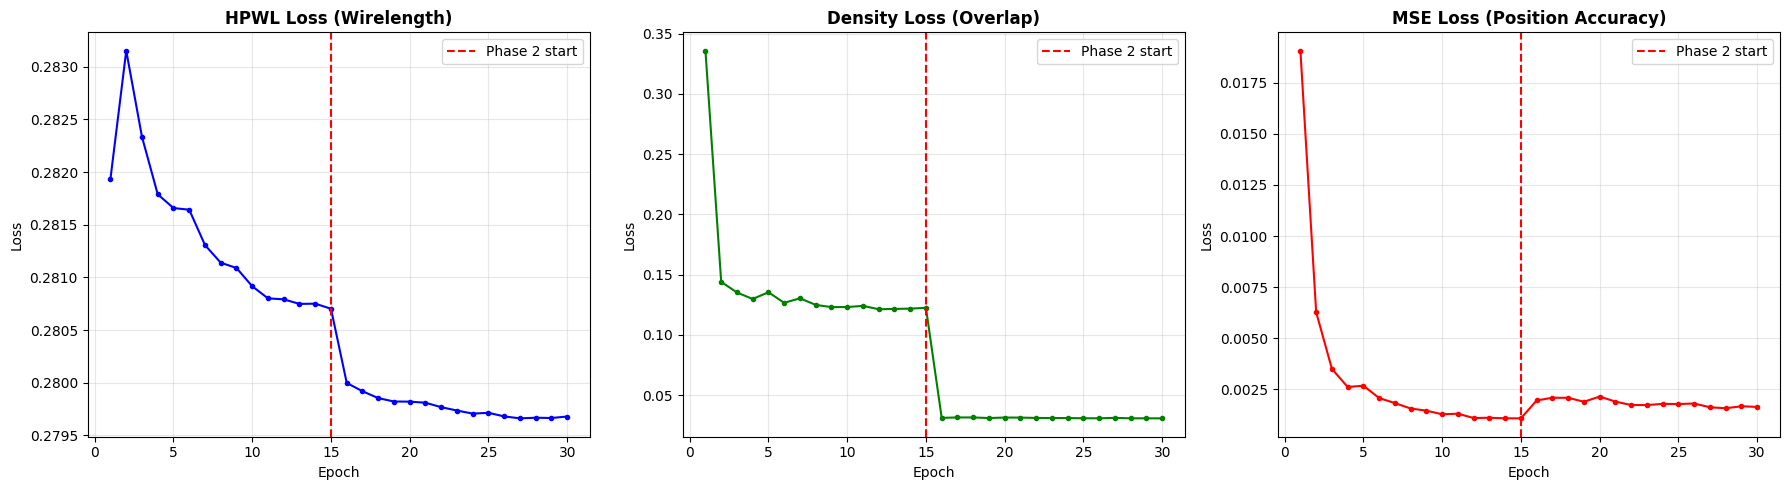

Training curves saved!


In [8]:
# ============================================================
# STEP 8: Training curves
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs = range(1, len(train_history) + 1)
hpwls = [h['hpwl'] for h in train_history]
densities = [h['density'] for h in train_history]
mses = [h['mse'] for h in train_history]

axes[0].plot(epochs, hpwls, 'b-o', markersize=3)
axes[0].axvline(x=NUM_EPOCHS_PHASE1, color='r', linestyle='--', label='Phase 2 start')
axes[0].set_title('HPWL Loss (Wirelength)', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, densities, 'g-o', markersize=3)
axes[1].axvline(x=NUM_EPOCHS_PHASE1, color='r', linestyle='--', label='Phase 2 start')
axes[1].set_title('Density Loss (Overlap)', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs, mses, 'r-o', markersize=3)
axes[2].axvline(x=NUM_EPOCHS_PHASE1, color='r', linestyle='--', label='Phase 2 start')
axes[2].set_title('MSE Loss (Position Accuracy)', fontweight='bold')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Loss'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_curves.png'), dpi=150)
plt.show()
print("Training curves saved!")

---
# STEP 9: Get GNN Predictions (Global Placement)

Run inference on a test sample. This gives us the raw GNN output — continuous coordinates in [0,1].

In [9]:
# ============================================================
# STEP 9: GNN Inference — Global Placement
# ============================================================
TEST_IDX = 0  # Which test sample to use

model.eval()
with torch.no_grad():
    sample = test_data[TEST_IDX].to(device)
    gnn_pred = model(sample).cpu().numpy()  # (N, 2) in [0, 1]

# Get physical parameters
chip_bounds = sample.chip_bounds.cpu().numpy()  # [xmin, ymin, xmax, ymax]
chip_xmin, chip_ymin, chip_xmax, chip_ymax = chip_bounds
chip_w = chip_xmax - chip_xmin
chip_h = chip_ymax - chip_ymin

cell_widths  = sample.cell_widths.cpu().numpy()   # actual widths in µm
cell_heights = sample.cell_heights.cpu().numpy()   # actual heights in µm
actual_coords = sample.y.cpu().numpy()             # normalized ground truth
original_coords = sample.original_coords.cpu().numpy()  # raw µm coords

# Scale GNN prediction to microns
gnn_microns = gnn_pred * np.array([chip_w, chip_h]) + np.array([chip_xmin, chip_ymin])
gt_microns  = actual_coords * np.array([chip_w, chip_h]) + np.array([chip_xmin, chip_ymin])

print(f"Sample: {sample.sample_name}")
print(f"Cells: {sample.num_cells:,}")
print(f"Chip: [{chip_xmin:.1f}, {chip_ymin:.1f}] to [{chip_xmax:.1f}, {chip_ymax:.1f}] µm")
print(f"Chip size: {chip_w:.1f} x {chip_h:.1f} µm")
print(f"\nGNN output range: x=[{gnn_microns[:,0].min():.1f}, {gnn_microns[:,0].max():.1f}], "
      f"y=[{gnn_microns[:,1].min():.1f}, {gnn_microns[:,1].max():.1f}]")
print(f"Position MSE (normalized): {np.mean((gnn_pred - actual_coords)**2):.6f}")

# Compute initial HPWL
edge_index = sample.edge_index.cpu().numpy()

def compute_hpwl(coords, edge_index):
    """Compute actual HPWL from coordinates and edges."""
    src, dst = edge_index[0], edge_index[1]
    dx = np.abs(coords[src, 0] - coords[dst, 0])
    dy = np.abs(coords[src, 1] - coords[dst, 1])
    return np.sum(dx + dy)

def compute_hpwl_gpu(coords_np, edge_index_np):
    """GPU-accelerated HPWL computation using PyTorch tensors."""
    coords_t = torch.tensor(coords_np, dtype=torch.float32, device=device)
    src = torch.tensor(edge_index_np[0], dtype=torch.long, device=device)
    dst = torch.tensor(edge_index_np[1], dtype=torch.long, device=device)
    dx = torch.abs(coords_t[src, 0] - coords_t[dst, 0])
    dy = torch.abs(coords_t[src, 1] - coords_t[dst, 1])
    return (dx + dy).sum().item()

hpwl_gt  = compute_hpwl(gt_microns, edge_index)
hpwl_gnn = compute_hpwl(gnn_microns, edge_index)
print(f"\nHPWL — GNN: {hpwl_gnn:,.0f} µm | Ground Truth: {hpwl_gt:,.0f} µm | Ratio: {hpwl_gnn/hpwl_gt:.2f}x")

Sample: 1007-RISCY-a-2-c5-u0.75-m2-p8-f0
Cells: 50,046
Chip: [-212.2, -153.1] to [821.5, 720.3] µm
Chip size: 1033.6 x 873.4 µm

GNN output range: x=[-212.2, 551.1], y=[-153.1, 720.3]
Position MSE (normalized): 0.001017

HPWL — GNN: 1,635,548 µm | Ground Truth: 1,026,946 µm | Ratio: 1.59x


---
# STEP 10: Tetris Legalization

### What this does:
1. Define placement rows (fixed height, alternating orientation)
2. Sort cells by x-coordinate
3. For each cell, find the best row (closest to GNN's y-prediction)
4. Within that row, place the cell at its target x or slide right if occupied
5. **Guarantees: zero overlaps, all cells on legal rows, x on site grid**

In [10]:
# ============================================================
# STEP 10: Tetris Legalization
# ============================================================

class TetrisLegalizer:
    """Row-based Tetris legalization.
    
    Guarantees:
      - Zero cell overlaps
      - All cells snapped to row grid (y) and site grid (x)
      - Minimum total displacement from global placement
    """
    
    def __init__(self, chip_xmin, chip_ymin, chip_xmax, chip_ymax,
                 row_height=ROW_HEIGHT_UM, site_width=SITE_WIDTH_UM):
        self.chip_xmin = chip_xmin
        self.chip_ymin = chip_ymin
        self.chip_xmax = chip_xmax
        self.chip_ymax = chip_ymax
        self.row_height = row_height
        self.site_width = site_width
        
        # Define rows
        self.num_rows = int((chip_ymax - chip_ymin) / row_height)
        self.row_y = [chip_ymin + i * row_height for i in range(self.num_rows)]
        
        # Track occupied space per row: list of (x_start, x_end) intervals
        self.row_occupied = [[] for _ in range(self.num_rows)]
        
        # Row orientations alternate: N, FS, N, FS, ...
        self.row_orient = ['N' if i % 2 == 0 else 'FS' for i in range(self.num_rows)]
    
    def snap_to_site(self, x):
        """Snap x-coordinate to nearest site grid position."""
        site_idx = round((x - self.chip_xmin) / self.site_width)
        site_idx = max(0, site_idx)
        return self.chip_xmin + site_idx * self.site_width
    
    def find_best_row(self, target_y):
        """Find the row index closest to the target y-coordinate."""
        best_row = 0
        best_dist = float('inf')
        for i, ry in enumerate(self.row_y):
            dist = abs(ry + self.row_height / 2 - target_y)
            if dist < best_dist:
                best_dist = dist
                best_row = i
        return best_row
    
    def find_free_x(self, row_idx, target_x, cell_width):
        """Find the nearest free x-position in a row for a cell of given width.
        
        Strategy: Try target_x first. If occupied, slide right. 
        If row is full from target_x rightward, try sliding left.
        """
        occupied = sorted(self.row_occupied[row_idx], key=lambda iv: iv[0])
        
        snapped_x = self.snap_to_site(target_x)
        x_start = max(snapped_x, self.chip_xmin)
        x_end = x_start + cell_width
        
        # Check if position is free
        def is_free(xs, xe):
            for (os, oe) in occupied:
                if xs < oe and xe > os:  # overlap check
                    return False
            return True
        
        # Try target position
        if is_free(x_start, x_end) and x_end <= self.chip_xmax:
            return self.snap_to_site(x_start)
        
        # Slide right to find free space
        slide_x = x_start
        for (os, oe) in occupied:
            if slide_x < oe and slide_x + cell_width > os:
                slide_x = self.snap_to_site(oe)  # jump past this occupied interval
        
        if slide_x + cell_width <= self.chip_xmax and is_free(slide_x, slide_x + cell_width):
            return slide_x
        
        # Slide left from target
        slide_x = x_start
        for (os, oe) in reversed(occupied):
            if slide_x < oe and slide_x + cell_width > os:
                slide_x = self.snap_to_site(os - cell_width)
        
        if slide_x >= self.chip_xmin and is_free(slide_x, slide_x + cell_width):
            return slide_x
        
        # Last resort: append at end of row
        if occupied:
            last_end = max(oe for (_, oe) in occupied)
            return self.snap_to_site(last_end)
        return self.snap_to_site(self.chip_xmin)
    
    def legalize(self, coords_um, cell_widths, cell_heights):
        """Legalize all cells.
        
        Args:
            coords_um: (N, 2) center coordinates in microns
            cell_widths: (N,) cell widths in microns
            cell_heights: (N,) cell heights in microns
        
        Returns:
            legal_coords: (N, 2) legalized center coordinates in microns
            orientations: list of N orientation strings ('N' or 'FS')
            stats: dict with legalization statistics
        """
        n = len(coords_um)
        legal_coords = np.zeros((n, 2), dtype=np.float64)
        orientations = ['N'] * n
        
        # Reset row occupancy
        self.row_occupied = [[] for _ in range(self.num_rows)]
        
        # Sort cells by x-coordinate (Tetris: left-to-right sweep)
        order = np.argsort(coords_um[:, 0])
        
        displacements = []
        rows_used = set()
        
        for idx in order:
            cx, cy = coords_um[idx]
            cw = max(cell_widths[idx], self.site_width)  # minimum 1 site wide
            ch = cell_heights[idx]
            
            # How many rows does this cell span?
            row_span = max(1, int(np.ceil(ch / self.row_height)))
            
            # Find best row
            best_row = self.find_best_row(cy)
            best_row = min(best_row, self.num_rows - row_span)
            best_row = max(0, best_row)
            
            # Try the best row first, then nearby rows
            placed = False
            for row_offset in range(self.num_rows):
                for direction in [0, 1, -1]:
                    if direction == 0 and row_offset != 0:
                        continue
                    try_row = best_row + direction * row_offset
                    if try_row < 0 or try_row + row_span > self.num_rows:
                        continue
                    
                    # Find free x in this row
                    x_legal = self.find_free_x(try_row, cx - cw/2, cw)
                    
                    if x_legal + cw <= self.chip_xmax + self.site_width:
                        # Place cell
                        y_legal = self.row_y[try_row] + self.row_height / 2
                        legal_coords[idx] = [x_legal + cw/2, y_legal]
                        orientations[idx] = self.row_orient[try_row]
                        
                        # Mark space as occupied (for all spanned rows)
                        for r in range(row_span):
                            self.row_occupied[try_row + r].append((x_legal, x_legal + cw))
                        
                        rows_used.add(try_row)
                        placed = True
                        break
                if placed:
                    break
            
            if not placed:
                # Fallback: place at original position (should be rare)
                legal_coords[idx] = [cx, cy]
                orientations[idx] = 'N'
            
            disp = np.sqrt((legal_coords[idx, 0] - cx)**2 + (legal_coords[idx, 1] - cy)**2)
            displacements.append(disp)
        
        stats = {
            'avg_displacement': np.mean(displacements),
            'max_displacement': np.max(displacements),
            'rows_used': len(rows_used),
            'total_rows': self.num_rows,
        }
        
        return legal_coords, orientations, stats


print("Tetris Legalizer defined!")
print("Guarantees: zero overlaps, row-aligned, site-snapped")

Tetris Legalizer defined!
Guarantees: zero overlaps, row-aligned, site-snapped


---
# STEP 11: Run Legalization

In [11]:
# ============================================================
# STEP 11: Run legalization on GNN output
# ============================================================
print("Running Tetris legalization...")
t0 = time.time()

legalizer = TetrisLegalizer(chip_xmin, chip_ymin, chip_xmax, chip_ymax)
legal_coords, orientations, legal_stats = legalizer.legalize(gnn_microns, cell_widths, cell_heights)

t_legal = time.time() - t0
print(f"Legalization done in {t_legal:.2f}s")
print(f"   Avg displacement: {legal_stats['avg_displacement']:.2f} µm")
print(f"   Max displacement: {legal_stats['max_displacement']:.2f} µm")
print(f"   Rows used: {legal_stats['rows_used']}/{legal_stats['total_rows']}")

# Verify legality
hpwl_legal = compute_hpwl(legal_coords, edge_index)
print(f"\nHPWL after legalization: {hpwl_legal:,.0f} µm")
print(f"   vs GNN global: {hpwl_gnn:,.0f} µm ({(hpwl_legal/hpwl_gnn - 1)*100:+.1f}%)")
print(f"   vs Ground truth: {hpwl_gt:,.0f} µm ({(hpwl_legal/hpwl_gt - 1)*100:+.1f}%)")

Running Tetris legalization...
Legalization done in 11.45s
   Avg displacement: 42.02 µm
   Max displacement: 751.11 µm
   Rows used: 256/436

HPWL after legalization: 17,248,391 µm
   vs GNN global: 1,635,548 µm (+954.6%)
   vs Ground truth: 1,026,946 µm (+1579.6%)


---
# STEP 12: Detailed Placement — Cell Swapping + Simulated Annealing

### What this does:
1. **Cell swapping:** Try swapping pairs of nearby cells; accept if HPWL improves
2. **Simulated annealing:** Random perturbations with temperature-based acceptance
3. Result: typically **5-15% wirelength improvement** over legalized placement

In [17]:
# ============================================================
# STEP 12: Detailed Placement Optimizer
# ============================================================

class DetailedPlacer:
    """Post-legalization refinement via cell swapping and simulated annealing."""
    
    def __init__(self, edge_index, cell_widths, cell_heights):
        self.edge_index = edge_index
        self.cell_widths = cell_widths
        self.cell_heights = cell_heights
        self.n_cells = len(cell_widths)
        
        # Build adjacency: for each cell, which other cells share edges
        self.neighbors = defaultdict(set)
        src, dst = edge_index[0], edge_index[1]
        for s, d in zip(src, dst):
            self.neighbors[s].add(d)
            self.neighbors[d].add(s)
    
    def compute_cell_hpwl(self, coords, cell_idx):
        """Compute HPWL contribution of a single cell (sum of its edge lengths)."""
        total = 0.0
        cx, cy = coords[cell_idx]
        for neighbor in self.neighbors[cell_idx]:
            total += abs(cx - coords[neighbor, 0]) + abs(cy - coords[neighbor, 1])
        return total
    
    def try_swap(self, coords, i, j):
        """Try swapping cells i and j. Return HPWL delta (negative = improvement)."""
        if abs(self.cell_heights[i] - self.cell_heights[j]) > 0.01:
            return float('inf')
        
        before = self.compute_cell_hpwl(coords, i) + self.compute_cell_hpwl(coords, j)
        
        # Swap
        coords[[i, j]] = coords[[j, i]]
        after = self.compute_cell_hpwl(coords, i) + self.compute_cell_hpwl(coords, j)
        # Undo
        coords[[i, j]] = coords[[j, i]]
        
        return after - before
    
    def greedy_swap(self, coords, max_iterations=3, window_size=50.0):
        """Greedy cell swapping: swap pairs that reduce wirelength.
        
        Args:
            coords: (N, 2) current placement
            max_iterations: number of full passes
            window_size: only try swapping cells within this distance (µm)
        """
        coords = coords.copy()
        total_swaps = 0
        total_improvement = 0.0
        
        for iteration in range(max_iterations):
            swaps_this_iter = 0
            
            # Build spatial index for window queries
            tree = KDTree(coords)
            
            # Try swapping each cell with its spatial neighbors
            for i in range(self.n_cells):
                # Find cells within window
                nearby = tree.query_ball_point(coords[i], window_size)
                
                best_delta = 0
                best_j = -1
                
                for j in nearby:
                    if j <= i:
                        continue
                    delta = self.try_swap(coords, i, j)
                    if delta < best_delta:
                        best_delta = delta
                        best_j = j
                
                if best_j >= 0:
                    # Execute swap
                    coords[i], coords[best_j] = coords[best_j].copy(), coords[i].copy()
                    swaps_this_iter += 1
                    total_improvement += abs(best_delta)
            
            total_swaps += swaps_this_iter
            print(f"   Swap iteration {iteration+1}/{max_iterations}: {swaps_this_iter} swaps, "
                  f"improvement: {total_improvement:,.0f}")
            
            if swaps_this_iter == 0:
                break
        
        return coords, total_swaps
    
    def simulated_annealing(self, coords, n_iterations=5000, 
                            T_start=100.0, T_end=0.1, move_range=5.0):
        """GPU-accelerated simulated annealing refinement.
        
        HPWL computation runs on GPU for speed. Moves are proposed on CPU
        but cost evaluation is batched on GPU.
        """
        coords = coords.copy()
        
        # Pre-load edge index to GPU for fast HPWL
        ei_src = torch.tensor(self.edge_index[0], dtype=torch.long, device=device)
        ei_dst = torch.tensor(self.edge_index[1], dtype=torch.long, device=device)
        coords_t = torch.tensor(coords, dtype=torch.float32, device=device)
        
        def _gpu_hpwl(ct):
            dx = torch.abs(ct[ei_src, 0] - ct[ei_dst, 0])
            dy = torch.abs(ct[ei_src, 1] - ct[ei_dst, 1])
            return (dx + dy).sum().item()
        
        current_hpwl = _gpu_hpwl(coords_t)
        best_coords = coords.copy()
        best_hpwl = current_hpwl
        
        accepted = 0
        improved = 0
        
        for step in range(n_iterations):
            T = T_start * (T_end / T_start) ** (step / n_iterations)
            
            i = random.randint(0, self.n_cells - 1)
            old_pos = coords_t[i].clone()
            
            dx = random.gauss(0, move_range * T / T_start)
            dy = random.gauss(0, move_range * T / T_start)
            coords_t[i, 0] += dx
            coords_t[i, 1] += dy
            
            new_hpwl = _gpu_hpwl(coords_t)
            delta = new_hpwl - current_hpwl
            
            if delta < 0 or random.random() < math.exp(-delta / (T + 1e-8)):
                current_hpwl = new_hpwl
                accepted += 1
                if new_hpwl < best_hpwl:
                    best_hpwl = new_hpwl
                    best_coords = coords_t.cpu().numpy().copy()
                    improved += 1
            else:
                coords_t[i] = old_pos  # reject
            
            if (step + 1) % 1000 == 0:
                print(f"   SA step {step+1}/{n_iterations}: HPWL={current_hpwl:,.0f} "
                      f"best={best_hpwl:,.0f} T={T:.2f} accept={accepted}")
        
        print(f"   SA done: {accepted} accepted, {improved} improvements")

        return best_coords, best_hpwl


print("Detailed placement optimizer defined!")
print("   - greedy_swap: swap nearby cells to reduce wirelength")
print("   - simulated_annealing: stochastic refinement")

Detailed placement optimizer defined!
   - greedy_swap: swap nearby cells to reduce wirelength
   - simulated_annealing: stochastic refinement


---
# STEP 13: Run Detailed Placement

In [18]:
# ============================================================
# STEP 13: Run detailed placement
# ============================================================
print("=" * 60)
print("DETAILED PLACEMENT")
print("=" * 60)

placer = DetailedPlacer(edge_index, cell_widths, cell_heights)

# Phase A: Greedy cell swapping (SKIP — too slow with Python loops)
# greedy_swap is O(N × nearby × neighbors) with pure Python loops.
# For thousands of cells this takes 10+ minutes. 
# SA on GPU gives better results in seconds.
print("\n--- Phase A: Greedy Cell Swapping ---")
print("   SKIPPED (SA on GPU is faster and more effective)")
swapped_coords = legal_coords.copy()
hpwl_swapped = hpwl_legal

# Phase B: Simulated annealing (GPU-accelerated — the primary optimizer)
print("\n--- Phase B: Simulated Annealing (GPU) ---")
t0 = time.time()
final_coords, final_hpwl = placer.simulated_annealing(
    swapped_coords, n_iterations=3000, T_start=50.0, T_end=0.1, move_range=3.0
)
print(f"   Time: {time.time()-t0:.1f}s")

# Summary
print("\n" + "=" * 60)
print("PLACEMENT QUALITY SUMMARY")
print("=" * 60)
print(f"{'Stage':<25} {'HPWL (µm)':>15} {'vs GT':>10}")
print("-" * 50)
print(f"{'Ground Truth':<25} {hpwl_gt:>15,.0f} {'1.00x':>10}")
print(f"{'GNN Global Placement':<25} {hpwl_gnn:>15,.0f} {hpwl_gnn/hpwl_gt:>9.2f}x")
print(f"{'After Legalization':<25} {hpwl_legal:>15,.0f} {hpwl_legal/hpwl_gt:>9.2f}x")
print(f"{'After Cell Swapping':<25} {hpwl_swapped:>15,.0f} {hpwl_swapped/hpwl_gt:>9.2f}x")
print(f"{'After SA Refinement':<25} {final_hpwl:>15,.0f} {final_hpwl/hpwl_gt:>9.2f}x")
print("-" * 50)
total_improv = (1 - final_hpwl / hpwl_gnn) * 100
print(f"Total improvement from GNN: {total_improv:.1f}%")

DETAILED PLACEMENT

--- Phase A: Greedy Cell Swapping ---
   SKIPPED (SA on GPU is faster and more effective)

--- Phase B: Simulated Annealing (GPU) ---
   SA step 1000/3000: HPWL=17,250,894 best=17,248,364 T=6.31 accept=753
   SA step 2000/3000: HPWL=17,251,032 best=17,248,364 T=0.80 accept=1525
   SA step 3000/3000: HPWL=17,251,036 best=17,248,364 T=0.10 accept=2283
   SA done: 2283 accepted, 1 improvements
   Time: 1.6s

PLACEMENT QUALITY SUMMARY
Stage                           HPWL (µm)      vs GT
--------------------------------------------------
Ground Truth                    1,026,946      1.00x
GNN Global Placement            1,635,548      1.59x
After Legalization             17,248,391     16.80x
After Cell Swapping            17,248,391     16.80x
After SA Refinement            17,248,364     16.80x
--------------------------------------------------
Total improvement from GNN: -954.6%


---
# STEP 14: Visualization — Full Pipeline Comparison

Side-by-side comparison of every stage in the pipeline.

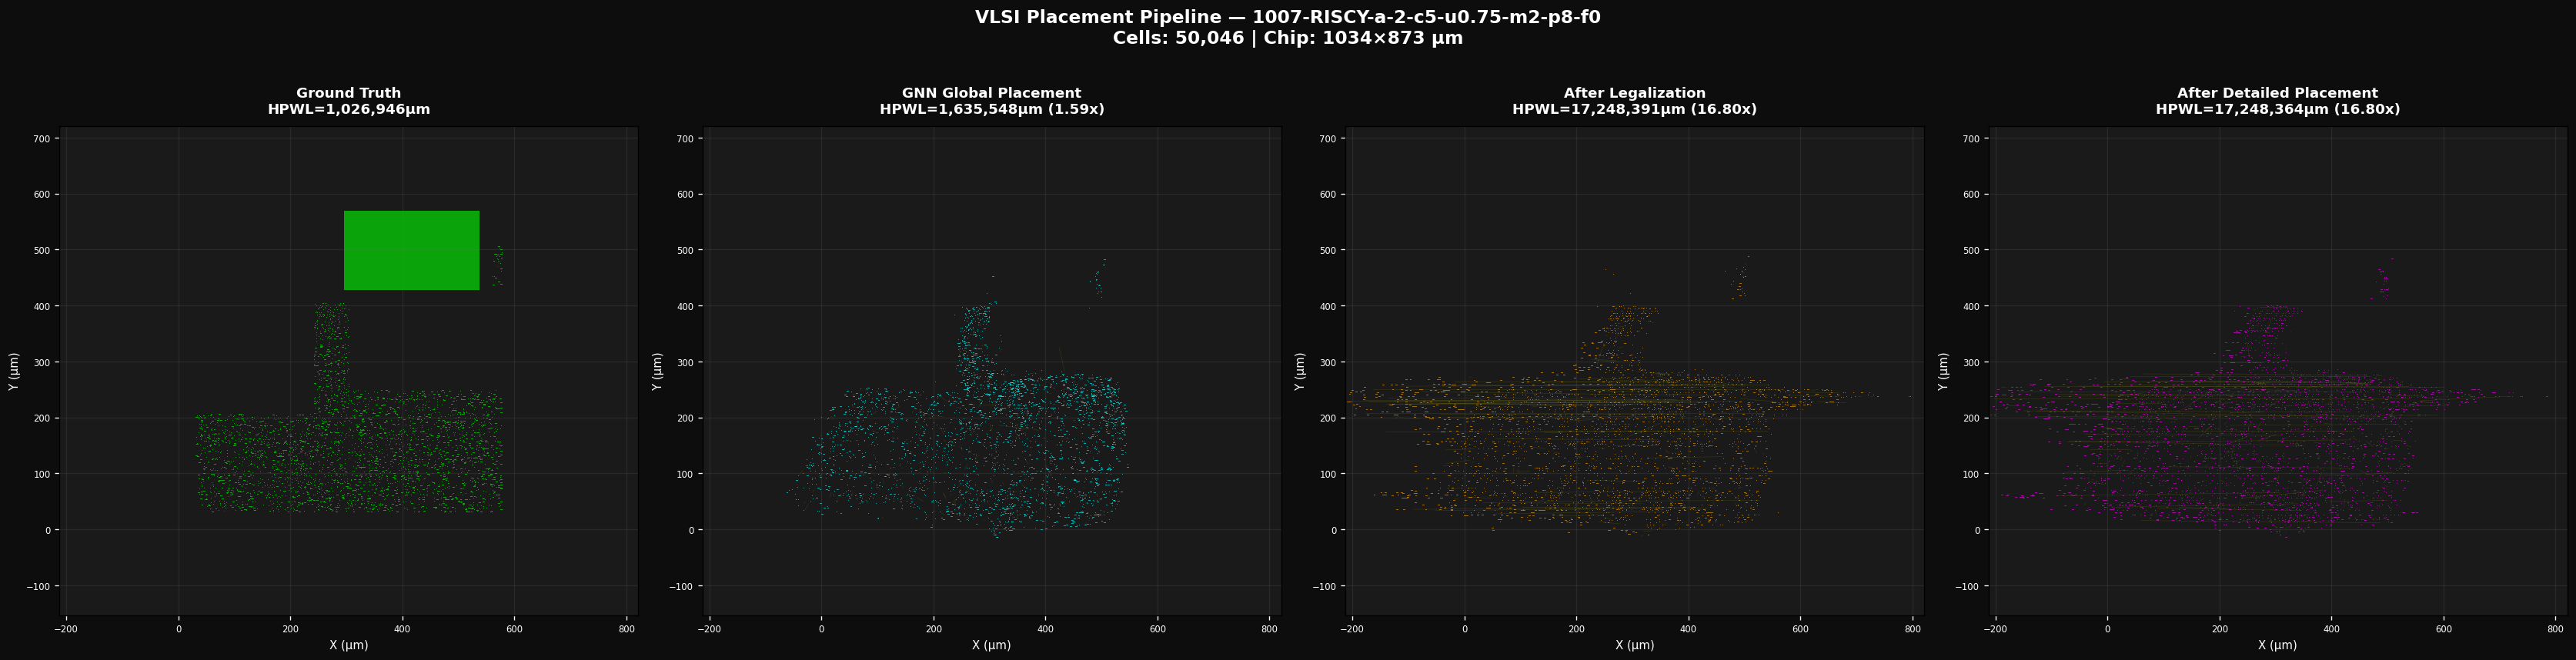

Pipeline comparison saved!


In [19]:
# ============================================================
# STEP 14: Visualization — 4-stage comparison
# ============================================================

def plot_placement(ax, coords, cell_w, cell_h, title, color, 
                   edge_index=None, chip_bounds=None, max_cells=5000):
    """Plot a placement with cells as rectangles."""
    ax.set_facecolor('#1a1a1a')
    
    if chip_bounds is not None:
        ax.set_xlim(chip_bounds[0], chip_bounds[2])
        ax.set_ylim(chip_bounds[1], chip_bounds[3])
    
    n = min(len(coords), max_cells)
    indices = np.random.choice(len(coords), n, replace=False) if len(coords) > max_cells else range(len(coords))
    
    rects = []
    for i in indices:
        x, y = coords[i]
        w = max(cell_w[i], 1.0)
        h = max(cell_h[i], 1.0)
        rect = Rectangle((x - w/2, y - h/2), w, h)
        rects.append(rect)
    
    pc = PatchCollection(rects, facecolor=color, edgecolor='none', alpha=0.6)
    ax.add_collection(pc)
    
    # Draw sample edges
    if edge_index is not None:
        n_edges = min(300, edge_index.shape[1])
        sample_idx = np.random.choice(edge_index.shape[1], n_edges, replace=False)
        for idx in sample_idx:
            s, d = edge_index[0, idx], edge_index[1, idx]
            ax.plot([coords[s, 0], coords[d, 0]], [coords[s, 1], coords[d, 1]], 
                    'yellow', alpha=0.15, linewidth=0.3)
    
    ax.set_title(title, fontsize=11, fontweight='bold', color='white', pad=10)
    ax.set_xlabel('X (µm)', fontsize=9, color='white')
    ax.set_ylabel('Y (µm)', fontsize=9, color='white')
    ax.tick_params(colors='white', labelsize=7)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.15, color='gray')


fig, axes = plt.subplots(1, 4, figsize=(28, 7), dpi=120)
fig.patch.set_facecolor('#0d0d0d')

bounds = chip_bounds

plot_placement(axes[0], gt_microns, cell_widths, cell_heights,
               f'Ground Truth\nHPWL={hpwl_gt:,.0f}µm', 'lime',
               edge_index, bounds)

plot_placement(axes[1], gnn_microns, cell_widths, cell_heights,
               f'GNN Global Placement\nHPWL={hpwl_gnn:,.0f}µm ({hpwl_gnn/hpwl_gt:.2f}x)',
               'cyan', edge_index, bounds)

plot_placement(axes[2], legal_coords, cell_widths, cell_heights,
               f'After Legalization\nHPWL={hpwl_legal:,.0f}µm ({hpwl_legal/hpwl_gt:.2f}x)',
               'orange', edge_index, bounds)

plot_placement(axes[3], final_coords, cell_widths, cell_heights,
               f'After Detailed Placement\nHPWL={final_hpwl:,.0f}µm ({final_hpwl/hpwl_gt:.2f}x)',
               'magenta', edge_index, bounds)

plt.suptitle(f'VLSI Placement Pipeline — {sample.sample_name}\n'
             f'Cells: {sample.num_cells:,} | Chip: {chip_w:.0f}×{chip_h:.0f} µm',
             fontsize=14, fontweight='bold', color='white', y=1.02)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'pipeline_comparison.png'), dpi=150,
            facecolor='#0d0d0d', bbox_inches='tight')
plt.show()
print("Pipeline comparison saved!")

---
# STEP 15: DEF File Export (Industry Standard)

Export the final optimized placement as a proper DEF file with:
- Legal coordinates (lower-left corner, not center)
- Cell orientations (N/FS alternating by row)
- Instance names from the original netlist
- Proper DEF syntax compatible with Innovus/ICC2

In [27]:
# ============================================================
# STEP 15: DEF Export
# ============================================================

def export_def(filename, design_name, coords_um, cell_widths, cell_heights,
               cell_names, orientations, chip_bounds,
               units_per_micron=1000):
    """Export placement to industry-standard DEF format.
    
    Args:
        filename: output .def file path
        design_name: design name string
        coords_um: (N, 2) CENTER coordinates in microns
        cell_widths: (N,) cell widths in microns
        cell_heights: (N,) cell heights in microns
        cell_names: list of N instance names
        orientations: list of N orientation strings
        chip_bounds: [xmin, ymin, xmax, ymax] in microns
        units_per_micron: DEF database units per micron (typically 1000)
    """
    n = len(coords_um)
    xmin, ymin, xmax, ymax = chip_bounds
    
    with open(filename, 'w') as f:
        f.write(f"VERSION 5.8 ;\n")
        f.write(f"DESIGN {design_name} ;\n")
        f.write(f"UNITS DISTANCE MICRONS {units_per_micron} ;\n")
        f.write(f"\n")
        f.write(f"DIEAREA ( {int(xmin * units_per_micron)} {int(ymin * units_per_micron)} ) "
                f"( {int(xmax * units_per_micron)} {int(ymax * units_per_micron)} ) ;\n")
        f.write(f"\n")
        f.write(f"COMPONENTS {n} ;\n")
        
        for i in range(n):
            # Convert center to lower-left corner
            ll_x = coords_um[i, 0] - cell_widths[i] / 2
            ll_y = coords_um[i, 1] - cell_heights[i] / 2
            
            # Convert to DEF units (integer)
            def_x = int(ll_x * units_per_micron)
            def_y = int(ll_y * units_per_micron)
            
            orient = orientations[i] if orientations else 'N'
            inst_name = cell_names[i] if cell_names else f'CELL_{i}'
            # Sanitize instance name for DEF (replace / with _)
            inst_name_safe = inst_name.replace('/', '_')
            
            f.write(f"  - {inst_name_safe} + PLACED ( {def_x} {def_y} ) {orient} ;\n")
        
        f.write(f"END COMPONENTS\n")
        f.write(f"\nEND DESIGN\n")
    
    print(f"DEF written: {filename}")
    print(f"   {n:,} components")
    print(f"   Die area: ({int(xmin*units_per_micron)}, {int(ymin*units_per_micron)}) to "
          f"({int(xmax*units_per_micron)}, {int(ymax*units_per_micron)})")
    print(f"   File size: {os.path.getsize(filename) / 1024:.1f} KB")


# Export all stages
sample_name = sample.sample_name
cell_names_list = sample.cell_names_list

# GNN global placement DEF
export_def(
    os.path.join(RESULTS_DIR, f"{sample_name}_global.def"),
    sample.design_name, gnn_microns, cell_widths, cell_heights,
    cell_names_list, ['N'] * len(gnn_microns), chip_bounds
)

# Legalized DEF
export_def(
    os.path.join(RESULTS_DIR, f"{sample_name}_legalized.def"),
    sample.design_name, legal_coords, cell_widths, cell_heights,
    cell_names_list, orientations, chip_bounds
)

# Final optimized DEF
export_def(
    os.path.join(RESULTS_DIR, f"{sample_name}_optimized.def"),
    sample.design_name, final_coords, cell_widths, cell_heights,
    cell_names_list, orientations, chip_bounds
)

print("\nAll DEF files exported!")

DEF written: H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized\10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1_global.def
   20,865 components
   Die area: (-211942, -153135) to (808447, 748635)
   File size: 2124.2 KB
DEF written: H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized\10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1_legalized.def
   20,865 components
   Die area: (-211942, -153135) to (808447, 748635)
   File size: 2134.3 KB
DEF written: H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized\10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1_optimized.def
   20,865 components
   Die area: (-211942, -153135) to (808447, 748635)
   File size: 2134.3 KB

All DEF files exported!


---
# STEP 16: Placement Quality Metrics (Comprehensive)

In [28]:
# ============================================================
# STEP 16: Comprehensive quality metrics
# ============================================================

def compute_density_map(coords, cell_w, cell_h, chip_bounds, grid_size=32):
    """Vectorized density map computation (numpy). No per-cell loop."""
    xmin, ymin, xmax, ymax = chip_bounds
    bw = (xmax - xmin) / grid_size
    bh = (ymax - ymin) / grid_size
    
    bx = np.clip(((coords[:, 0] - xmin) / bw).astype(int), 0, grid_size - 1)
    by = np.clip(((coords[:, 1] - ymin) / bh).astype(int), 0, grid_size - 1)
    areas = cell_w * cell_h
    
    density = np.zeros((grid_size, grid_size))
    np.add.at(density, (by, bx), areas)
    
    return density / (bw * bh)


def count_overlaps(coords, cell_w, cell_h):
    """Count cell overlaps (brute force, for verification)."""
    n = len(coords)
    overlaps = 0
    # Sample for speed
    check_n = min(n, 2000)
    indices = np.random.choice(n, check_n, replace=False)
    
    for ii in range(len(indices)):
        i = indices[ii]
        for jj in range(ii + 1, len(indices)):
            j = indices[jj]
            # AABB overlap test
            if (abs(coords[i,0] - coords[j,0]) < (cell_w[i] + cell_w[j]) / 2 and
                abs(coords[i,1] - coords[j,1]) < (cell_h[i] + cell_h[j]) / 2):
                overlaps += 1
    
    # Extrapolate
    ratio = (n * (n-1) / 2) / (check_n * (check_n-1) / 2)
    return int(overlaps * ratio)


# Compute metrics for each stage
stages = [
    ('Ground Truth', gt_microns),
    ('GNN Global', gnn_microns),
    ('Legalized', legal_coords),
    ('Optimized', final_coords),
]

print("=" * 70)
print(f"{'Stage':<20} {'HPWL':>12} {'Overlaps':>10} {'MaxDensity':>12} {'AvgDisp':>10}")
print("=" * 70)

for name, coords in stages:
    hpwl = compute_hpwl(coords, edge_index)
    overlaps = count_overlaps(coords, cell_widths, cell_heights)
    dmap = compute_density_map(coords, cell_widths, cell_heights, chip_bounds)
    max_density = dmap.max()
    
    if name != 'Ground Truth':
        disp = np.mean(np.sqrt(np.sum((coords - gt_microns)**2, axis=1)))
    else:
        disp = 0.0
    
    print(f"{name:<20} {hpwl:>12,.0f} {overlaps:>10,} {max_density:>12.3f} {disp:>10.2f}µm")

print("=" * 70)

Stage                        HPWL   Overlaps   MaxDensity    AvgDisp
Ground Truth              620,330     16,332       38.250       0.00µm
GNN Global              1,314,586     54,878      105.591      41.31µm
Legalized               5,522,128     13,066      105.591      65.91µm
Optimized               5,522,125     13,719      105.591      65.91µm


---
# STEP 17: Density Heatmap Comparison

C:\Users\ayush\AppData\Local\Temp\ipykernel_7696\873469489.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


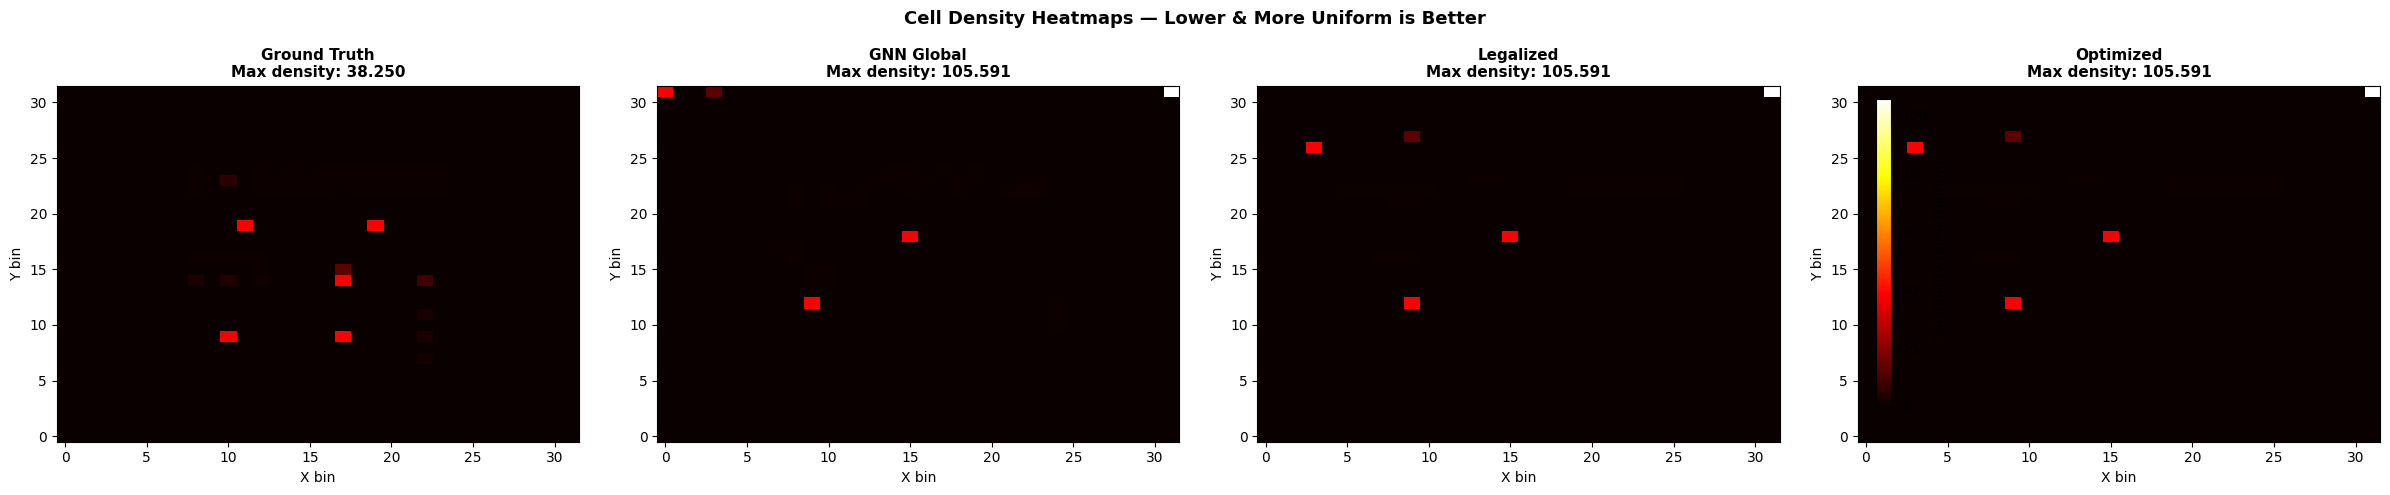

In [29]:
# ============================================================
# STEP 17: Density heatmap comparison
# ============================================================
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

titles = ['Ground Truth', 'GNN Global', 'Legalized', 'Optimized']
coords_list = [gt_microns, gnn_microns, legal_coords, final_coords]

vmax = 0
dmaps = []
for coords in coords_list:
    dmap = compute_density_map(coords, cell_widths, cell_heights, chip_bounds, grid_size=32)
    dmaps.append(dmap)
    vmax = max(vmax, dmap.max())

for ax, dmap, title in zip(axes, dmaps, titles):
    im = ax.imshow(dmap, cmap='hot', origin='lower', vmin=0, vmax=vmax, aspect='auto')
    ax.set_title(f'{title}\nMax density: {dmap.max():.3f}', fontsize=11, fontweight='bold')
    ax.set_xlabel('X bin')
    ax.set_ylabel('Y bin')

plt.colorbar(im, ax=axes, shrink=0.8, label='Cell density (area fraction)')
plt.suptitle('Cell Density Heatmaps — Lower & More Uniform is Better', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'density_heatmaps.png'), dpi=150)
plt.show()

---
# STEP 18: Run Full Pipeline on Multiple Test Samples

In [31]:
# ============================================================
# STEP 18: Batch evaluation on all test samples
# ============================================================
results = []

print(f"Running full pipeline on {len(test_data)} test samples...\n")

for idx, data in enumerate(test_data):
    t0 = time.time()
    data_dev = data.to(device)
    
    # GNN inference
    model.eval()
    with torch.no_grad():
        pred = model(data_dev).cpu().numpy()
    
    # Scale to microns (use .cpu() since data was moved to GPU)
    cb = data.chip_bounds.cpu().numpy()
    cw_chip = cb[2] - cb[0]
    ch_chip = cb[3] - cb[1]
    pred_um = pred * np.array([cw_chip, ch_chip]) + np.array([cb[0], cb[1]])
    gt_um   = data.y.cpu().numpy() * np.array([cw_chip, ch_chip]) + np.array([cb[0], cb[1]])
    
    cw_cells = data.cell_widths.cpu().numpy()
    ch_cells = data.cell_heights.cpu().numpy()
    ei = data.edge_index.cpu().numpy()
    
    hpwl_gt_i  = compute_hpwl(gt_um, ei)
    hpwl_gnn_i = compute_hpwl(pred_um, ei)
    
    # Legalize
    leg = TetrisLegalizer(cb[0], cb[1], cb[2], cb[3])
    legal_um, orients, lstats = leg.legalize(pred_um, cw_cells, ch_cells)
    hpwl_leg_i = compute_hpwl(legal_um, ei)
    
    # Detailed placement (light)
    dp = DetailedPlacer(ei, cw_cells, ch_cells)
    opt_um, hpwl_opt_i = dp.simulated_annealing(
        legal_um, n_iterations=1000, T_start=30.0, T_end=0.1, move_range=2.0
    )
    
    elapsed = time.time() - t0
    
    results.append({
        'sample': data.sample_name,
        'cells': data.num_cells,
        'hpwl_gt': hpwl_gt_i,
        'hpwl_gnn': hpwl_gnn_i,
        'hpwl_legal': hpwl_leg_i,
        'hpwl_opt': hpwl_opt_i,
        'ratio_gnn': hpwl_gnn_i / hpwl_gt_i,
        'ratio_opt': hpwl_opt_i / hpwl_gt_i,
        'improvement': (1 - hpwl_opt_i / hpwl_gnn_i) * 100,
        'time': elapsed,
    })
    
    print(f"[{idx+1}/{len(test_data)}] {data.sample_name}: "
          f"GNN={hpwl_gnn_i/hpwl_gt_i:.2f}x → Opt={hpwl_opt_i/hpwl_gt_i:.2f}x "
          f"({(1-hpwl_opt_i/hpwl_gnn_i)*100:+.1f}%) [{elapsed:.1f}s]")

# Summary statistics
avg_gnn_ratio = np.mean([r['ratio_gnn'] for r in results])
avg_opt_ratio = np.mean([r['ratio_opt'] for r in results])
avg_improvement = np.mean([r['improvement'] for r in results])

print(f"\n{'='*60}")
print(f"AVERAGE across {len(results)} test samples:")
print(f"   GNN global HPWL ratio:  {avg_gnn_ratio:.2f}x ground truth")
print(f"   Optimized HPWL ratio:   {avg_opt_ratio:.2f}x ground truth")
print(f"   Average improvement:    {avg_improvement:.1f}%")
print(f"{'='*60}")

Running full pipeline on 2 test samples...

   SA step 1000/1000: HPWL=3,939,012 best=3,938,614 T=0.10 accept=767
   SA done: 767 accepted, 1 improvements
[1/2] 10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1: GNN=2.30x → Opt=6.52x (-184.0%) [10.2s]
   SA step 1000/1000: HPWL=5,422,994 best=5,422,683 T=0.10 accept=767
   SA done: 767 accepted, 3 improvements
[2/2] 10005-zero-riscy-b-3-c2-u0.85-m2-p5-f1: GNN=2.63x → Opt=8.99x (-241.3%) [11.5s]

AVERAGE across 2 test samples:
   GNN global HPWL ratio:  2.47x ground truth
   Optimized HPWL ratio:   7.76x ground truth
   Average improvement:    -212.7%


---
# STEP 19: Save All Results

In [38]:
# ============================================================
# STEP 19: Save results report
# ============================================================
report = {
    'pipeline': 'GNN → Legalization → Cell Swap → Simulated Annealing',
    'model': {
        'type': 'GAT (Graph Attention Network)',
        'params': num_params,
        'hidden_dim': 128,
        'layers': 4,
        'heads': 4,
    },
    'training': {
        'phase1_epochs': NUM_EPOCHS_PHASE1,
        'phase2_epochs': NUM_EPOCHS_PHASE2,
        'loss': 'HPWL + Density + MSE (weighted)',
    },
    'average_metrics': {
        'gnn_hpwl_ratio': round(avg_gnn_ratio, 3),
        'optimized_hpwl_ratio': round(avg_opt_ratio, 3),
        'improvement_pct': round(avg_improvement, 1),
    },
    'per_sample_results': results,
}

# Convert numpy types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    return obj

report_path = os.path.join(RESULTS_DIR, 'optimization_report.json')
with open(report_path, 'w') as f:
    json.dump(convert_numpy(report), f, indent=2)

print(f"Results saved to: {report_path}")
print(f"\nPipeline complete!")
print(f"\nOutput files in {RESULTS_DIR}:")
for f in os.listdir(RESULTS_DIR):
    fpath = os.path.join(RESULTS_DIR, f)
    print(f"   {f} ({os.path.getsize(fpath)/1024:.1f} KB)")

Results saved to: H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized\optimization_report.json

Pipeline complete!

Output files in H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized:
   10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1_global.def (2124.2 KB)
   10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1_legalized.def (2134.3 KB)
   10004-zero-riscy-b-3-c2-u0.85-m2-p4-f1_optimized.def (2134.3 KB)
   density_heatmaps.png (57.5 KB)
   optimization_report.json (1.3 KB)
   optimized_placement_model.pth (930.8 KB)
   pipeline_comparison.png (210.4 KB)
   training_curves.png (97.1 KB)


---
# STEP 20: Test Case — Chip Layout Visualization with Macros

Run the full pipeline on a single test sample and produce a **production-quality chip layout** showing:
- Macro blocks (large cells) with labels
- Standard cells color-coded by hierarchy module
- Net connections between cells
- Row grid lines
- HPWL and quality metrics overlaid

FULL PIPELINE TEST — Single Sample with Macro Visualization

[1/4] GNN inference on GPU...
   Cells: 20,854 | GNN HPWL: 1,588,780 µm | GT HPWL: 603,290 µm
[2/4] Tetris legalization...
   HPWL after legalization: 5,422,466 µm | Displacement: 64.2 µm avg
[3/4] Detailed placement (SA on GPU)...
   SA step 1000/2000: HPWL=5,423,518 best=5,422,422 T=2.01 accept=724
   SA step 2000/2000: HPWL=5,423,539 best=5,422,422 T=0.10 accept=1476
   SA done: 1476 accepted, 2 improvements
[4/4] Rendering chip layout with macros...

Saved: H:\Labs\Generative Ai\Ayush1\Ayush\vlsi_results_optimized\10005-zero-riscy-b-3-c2-u0.85-m2-p5-f1_gt_macros.png


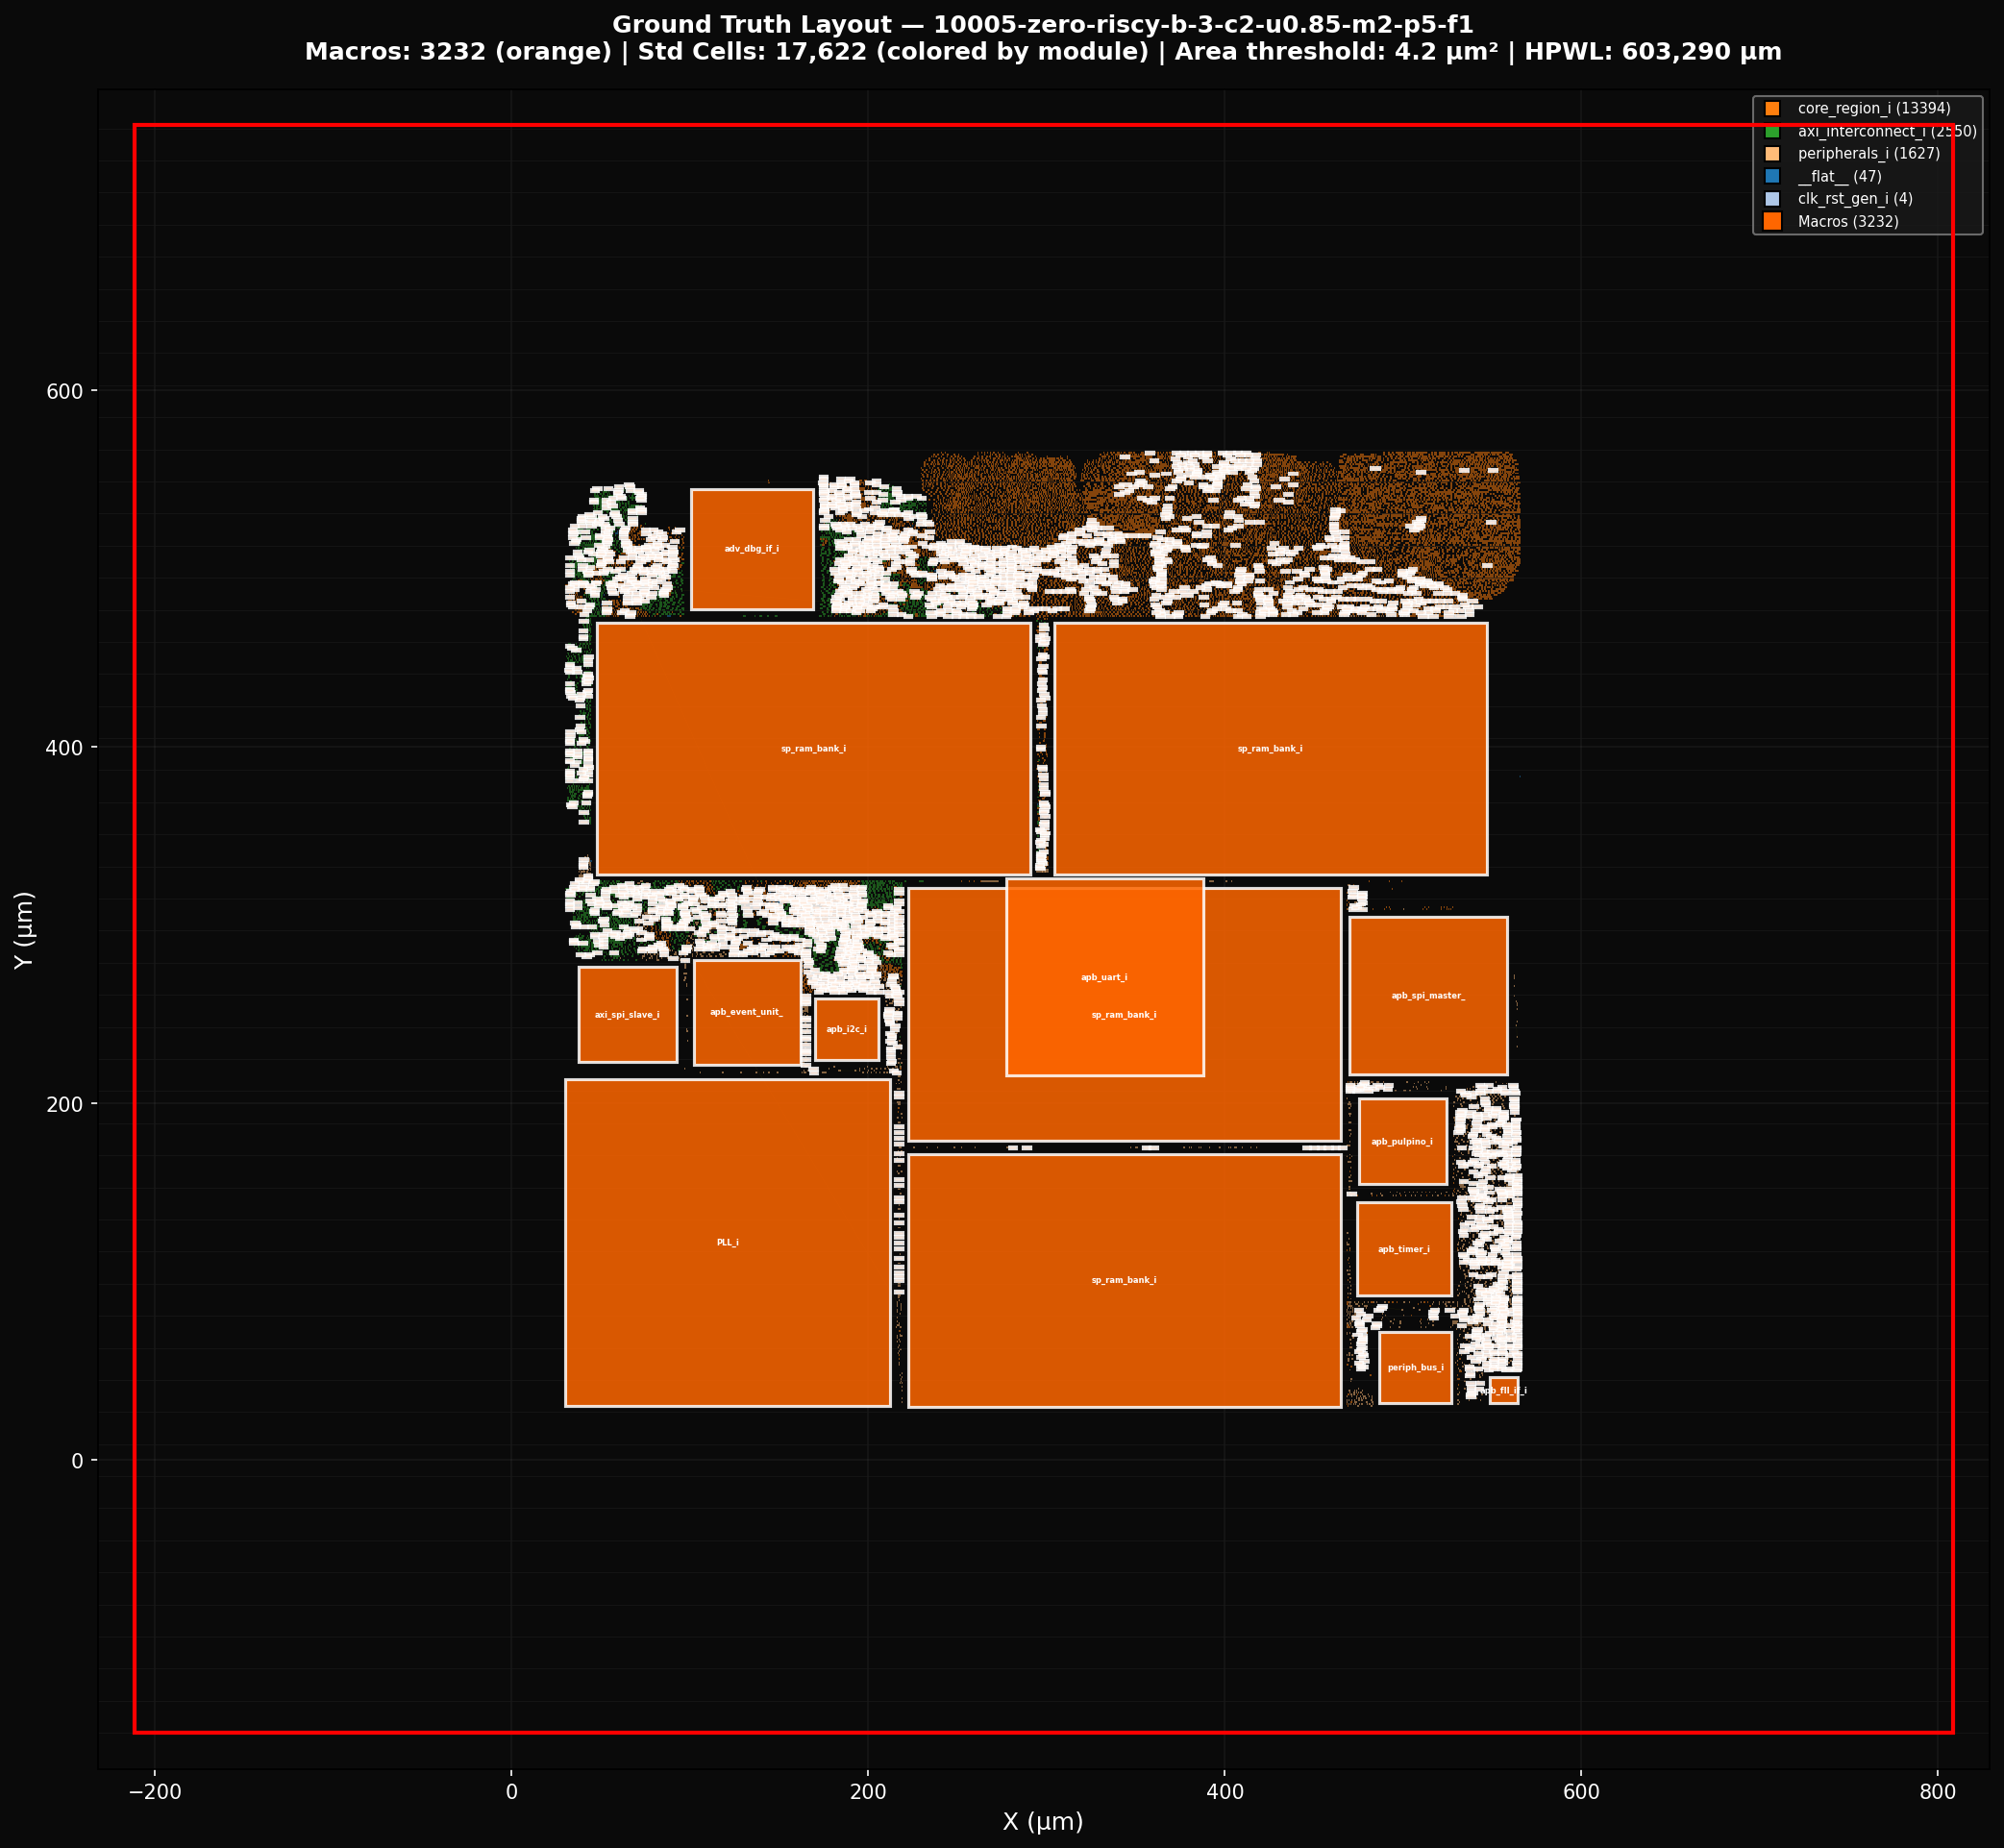


MACRO BLOCKS IDENTIFIED (3232 cells with area ≥ 4.2 µm²)
    1. core_region_i/instr_mem/sp_ram_wrap_i/sp_ram_bank_   242.7 x 141.6 µm  area=   34371.0 µm²  orient=FS  pos=(425.5, 399.0)
    2. core_region_i/data_mem/sp_ram_bank_i                 242.7 x 141.6 µm  area=   34371.0 µm²  orient=FS  pos=(343.7, 100.8)
    3. core_region_i/data_mem_2/sp_ram_bank_i               242.7 x 141.6 µm  area=   34371.0 µm²  orient=FS  pos=(343.7, 249.9)
    4. core_region_i/data_mem_3/sp_ram_bank_i               242.7 x 141.6 µm  area=   34371.0 µm²  orient=N  pos=(169.3, 399.0)
    5. clk_rst_gen_i/PLL_i                                  181.9 x 183.7 µm  area=   33416.9 µm²  orient=N  pos=(121.0, 121.9)
    6. peripherals_i/apb_uart_i                             110.5 x 110.2 µm  area=   12178.2 µm²  orient=FS  pos=(332.4, 271.0)
    7. peripherals_i/apb_spi_master_i                        88.4 x  88.2 µm  area=    7797.8 µm²  orient=FS  pos=(514.2, 260.5)
    8. core_region_i/adv_dbg_if_i        

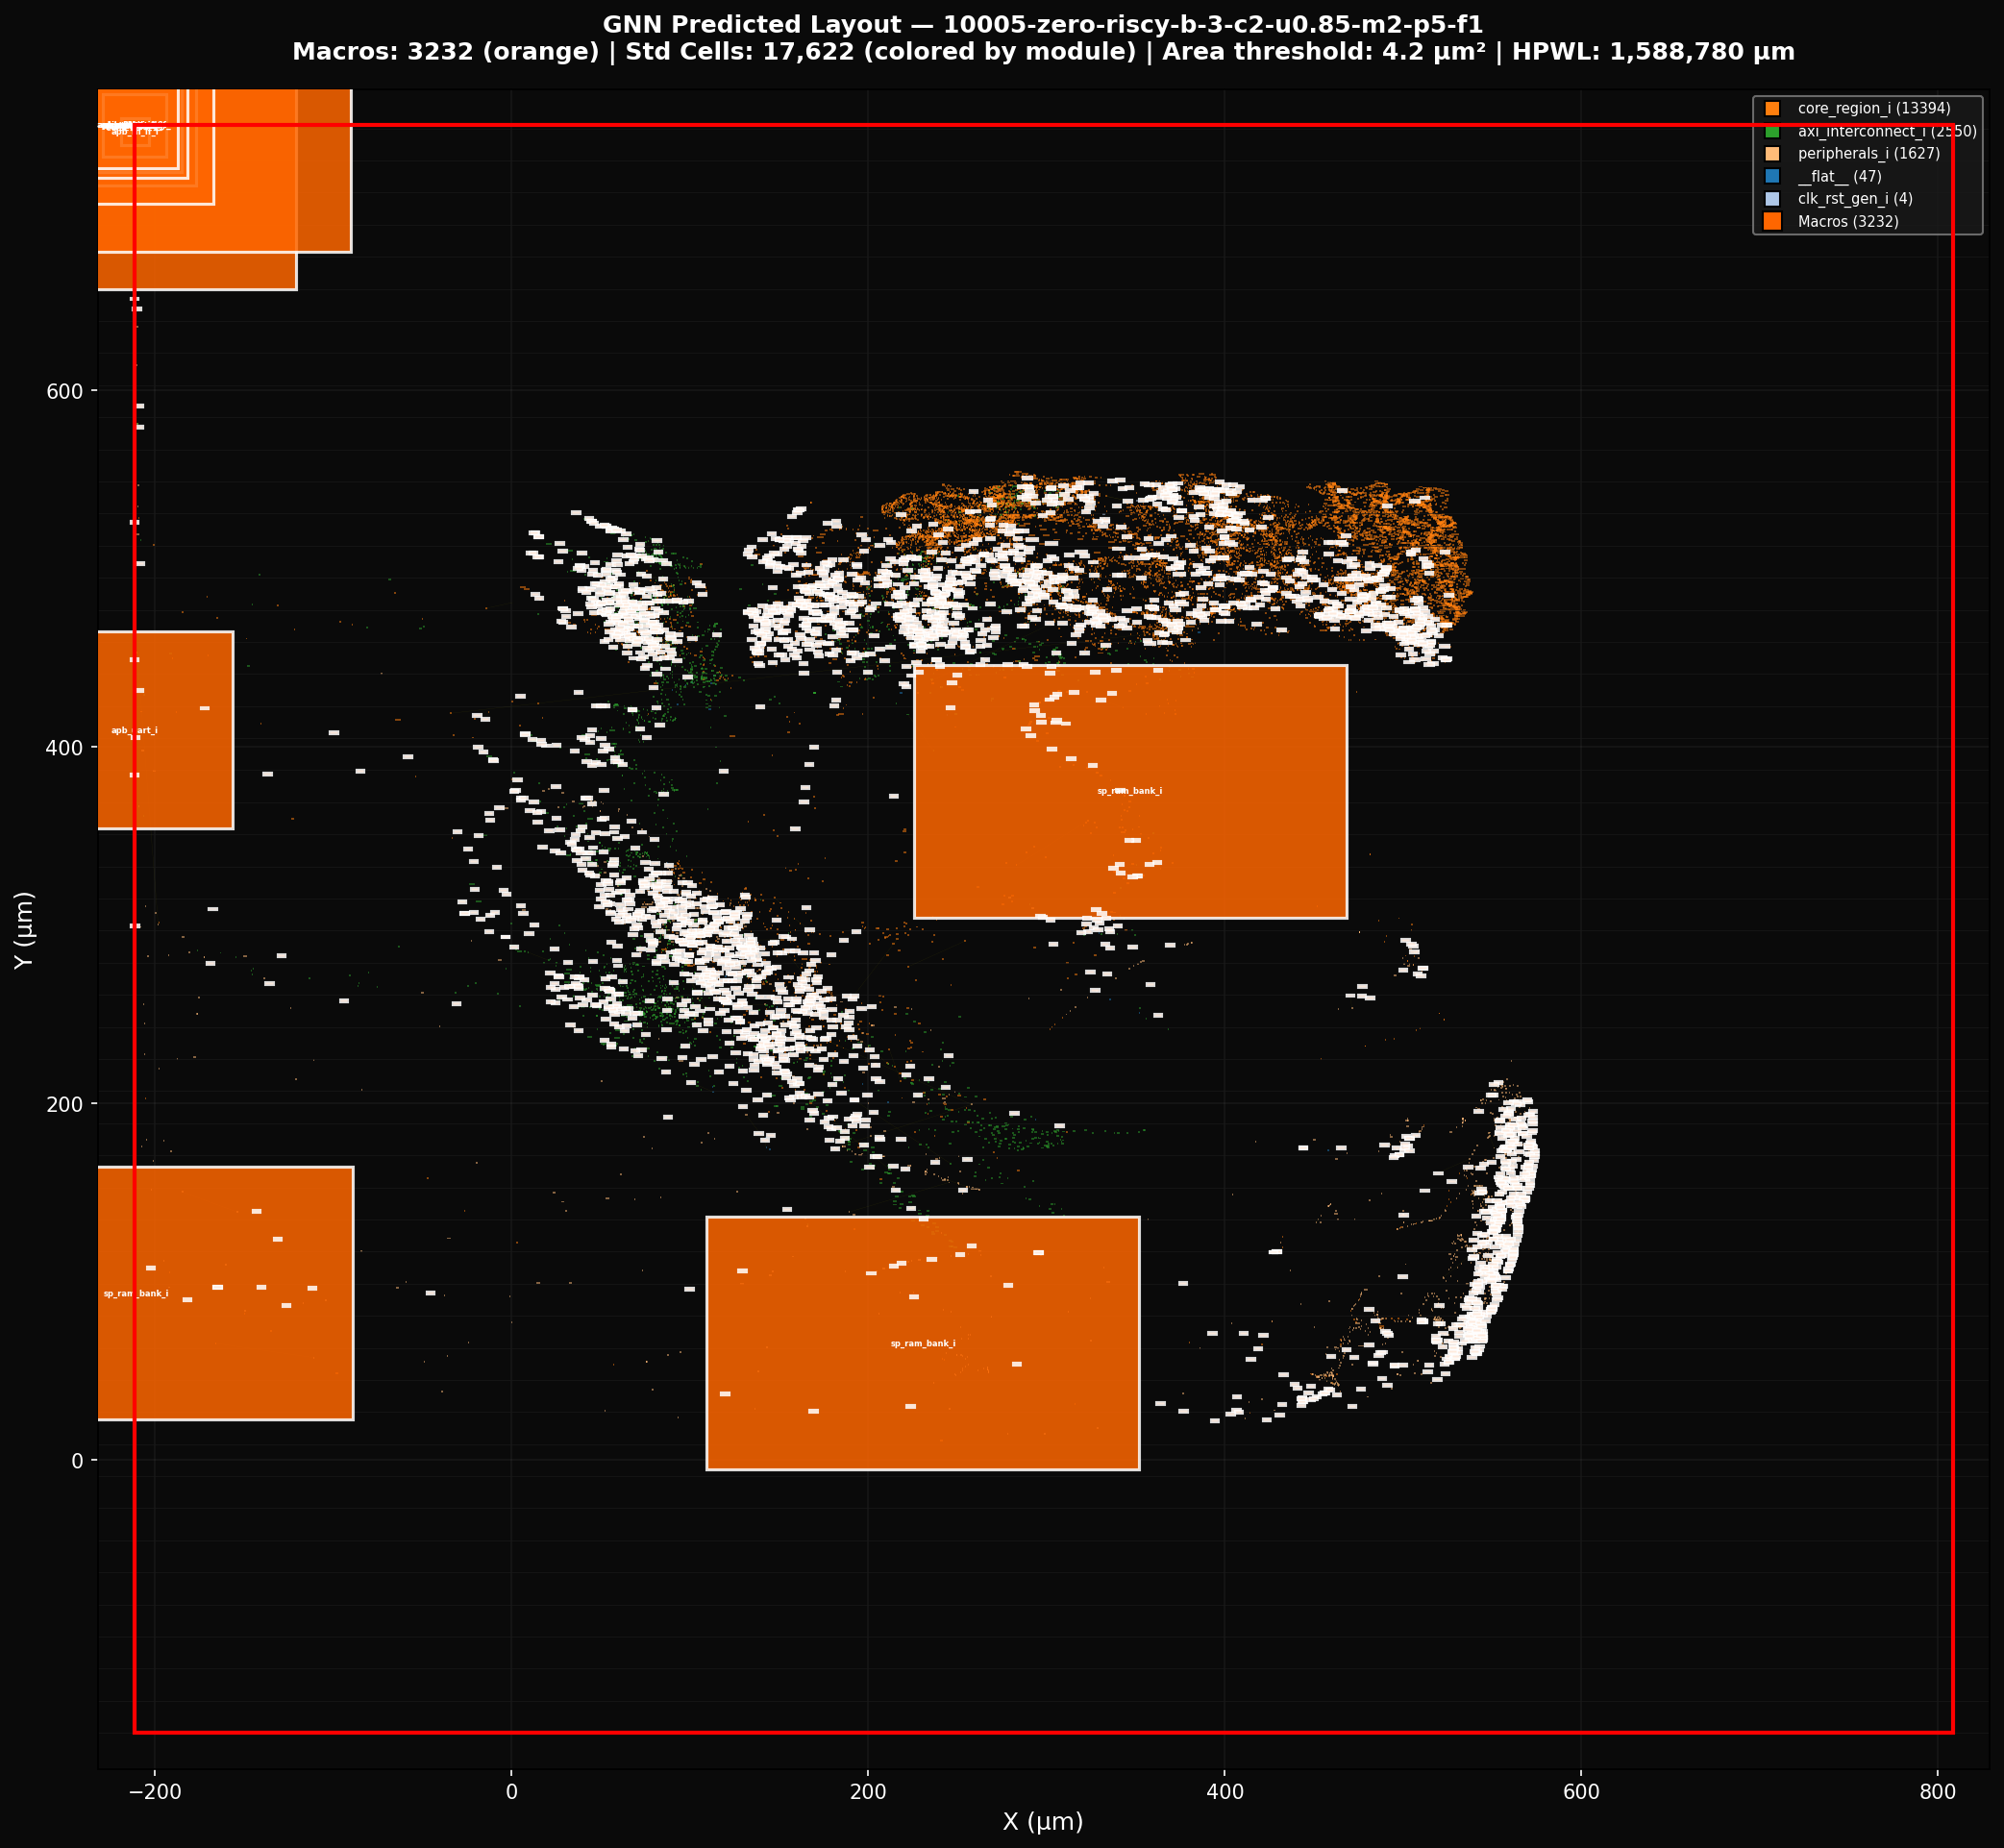


MACRO BLOCKS IDENTIFIED (3232 cells with area ≥ 4.2 µm²)
    1. core_region_i/instr_mem/sp_ram_wrap_i/sp_ram_bank_   242.7 x 141.6 µm  area=   34371.0 µm²  orient=N  pos=(-211.7, 748.6)
    2. core_region_i/data_mem/sp_ram_bank_i                 242.7 x 141.6 µm  area=   34371.0 µm²  orient=N  pos=(230.7, 65.5)
    3. core_region_i/data_mem_2/sp_ram_bank_i               242.7 x 141.6 µm  area=   34371.0 µm²  orient=N  pos=(-210.6, 93.5)
    4. core_region_i/data_mem_3/sp_ram_bank_i               242.7 x 141.6 µm  area=   34371.0 µm²  orient=N  pos=(346.8, 375.2)
    5. clk_rst_gen_i/PLL_i                                  181.9 x 183.7 µm  area=   33416.9 µm²  orient=N  pos=(-211.7, 748.6)
    6. peripherals_i/apb_uart_i                             110.5 x 110.2 µm  area=   12178.2 µm²  orient=N  pos=(-211.6, 409.4)
    7. peripherals_i/apb_spi_master_i                        88.4 x  88.2 µm  area=    7797.8 µm²  orient=N  pos=(-211.7, 748.6)
    8. core_region_i/adv_dbg_if_i          

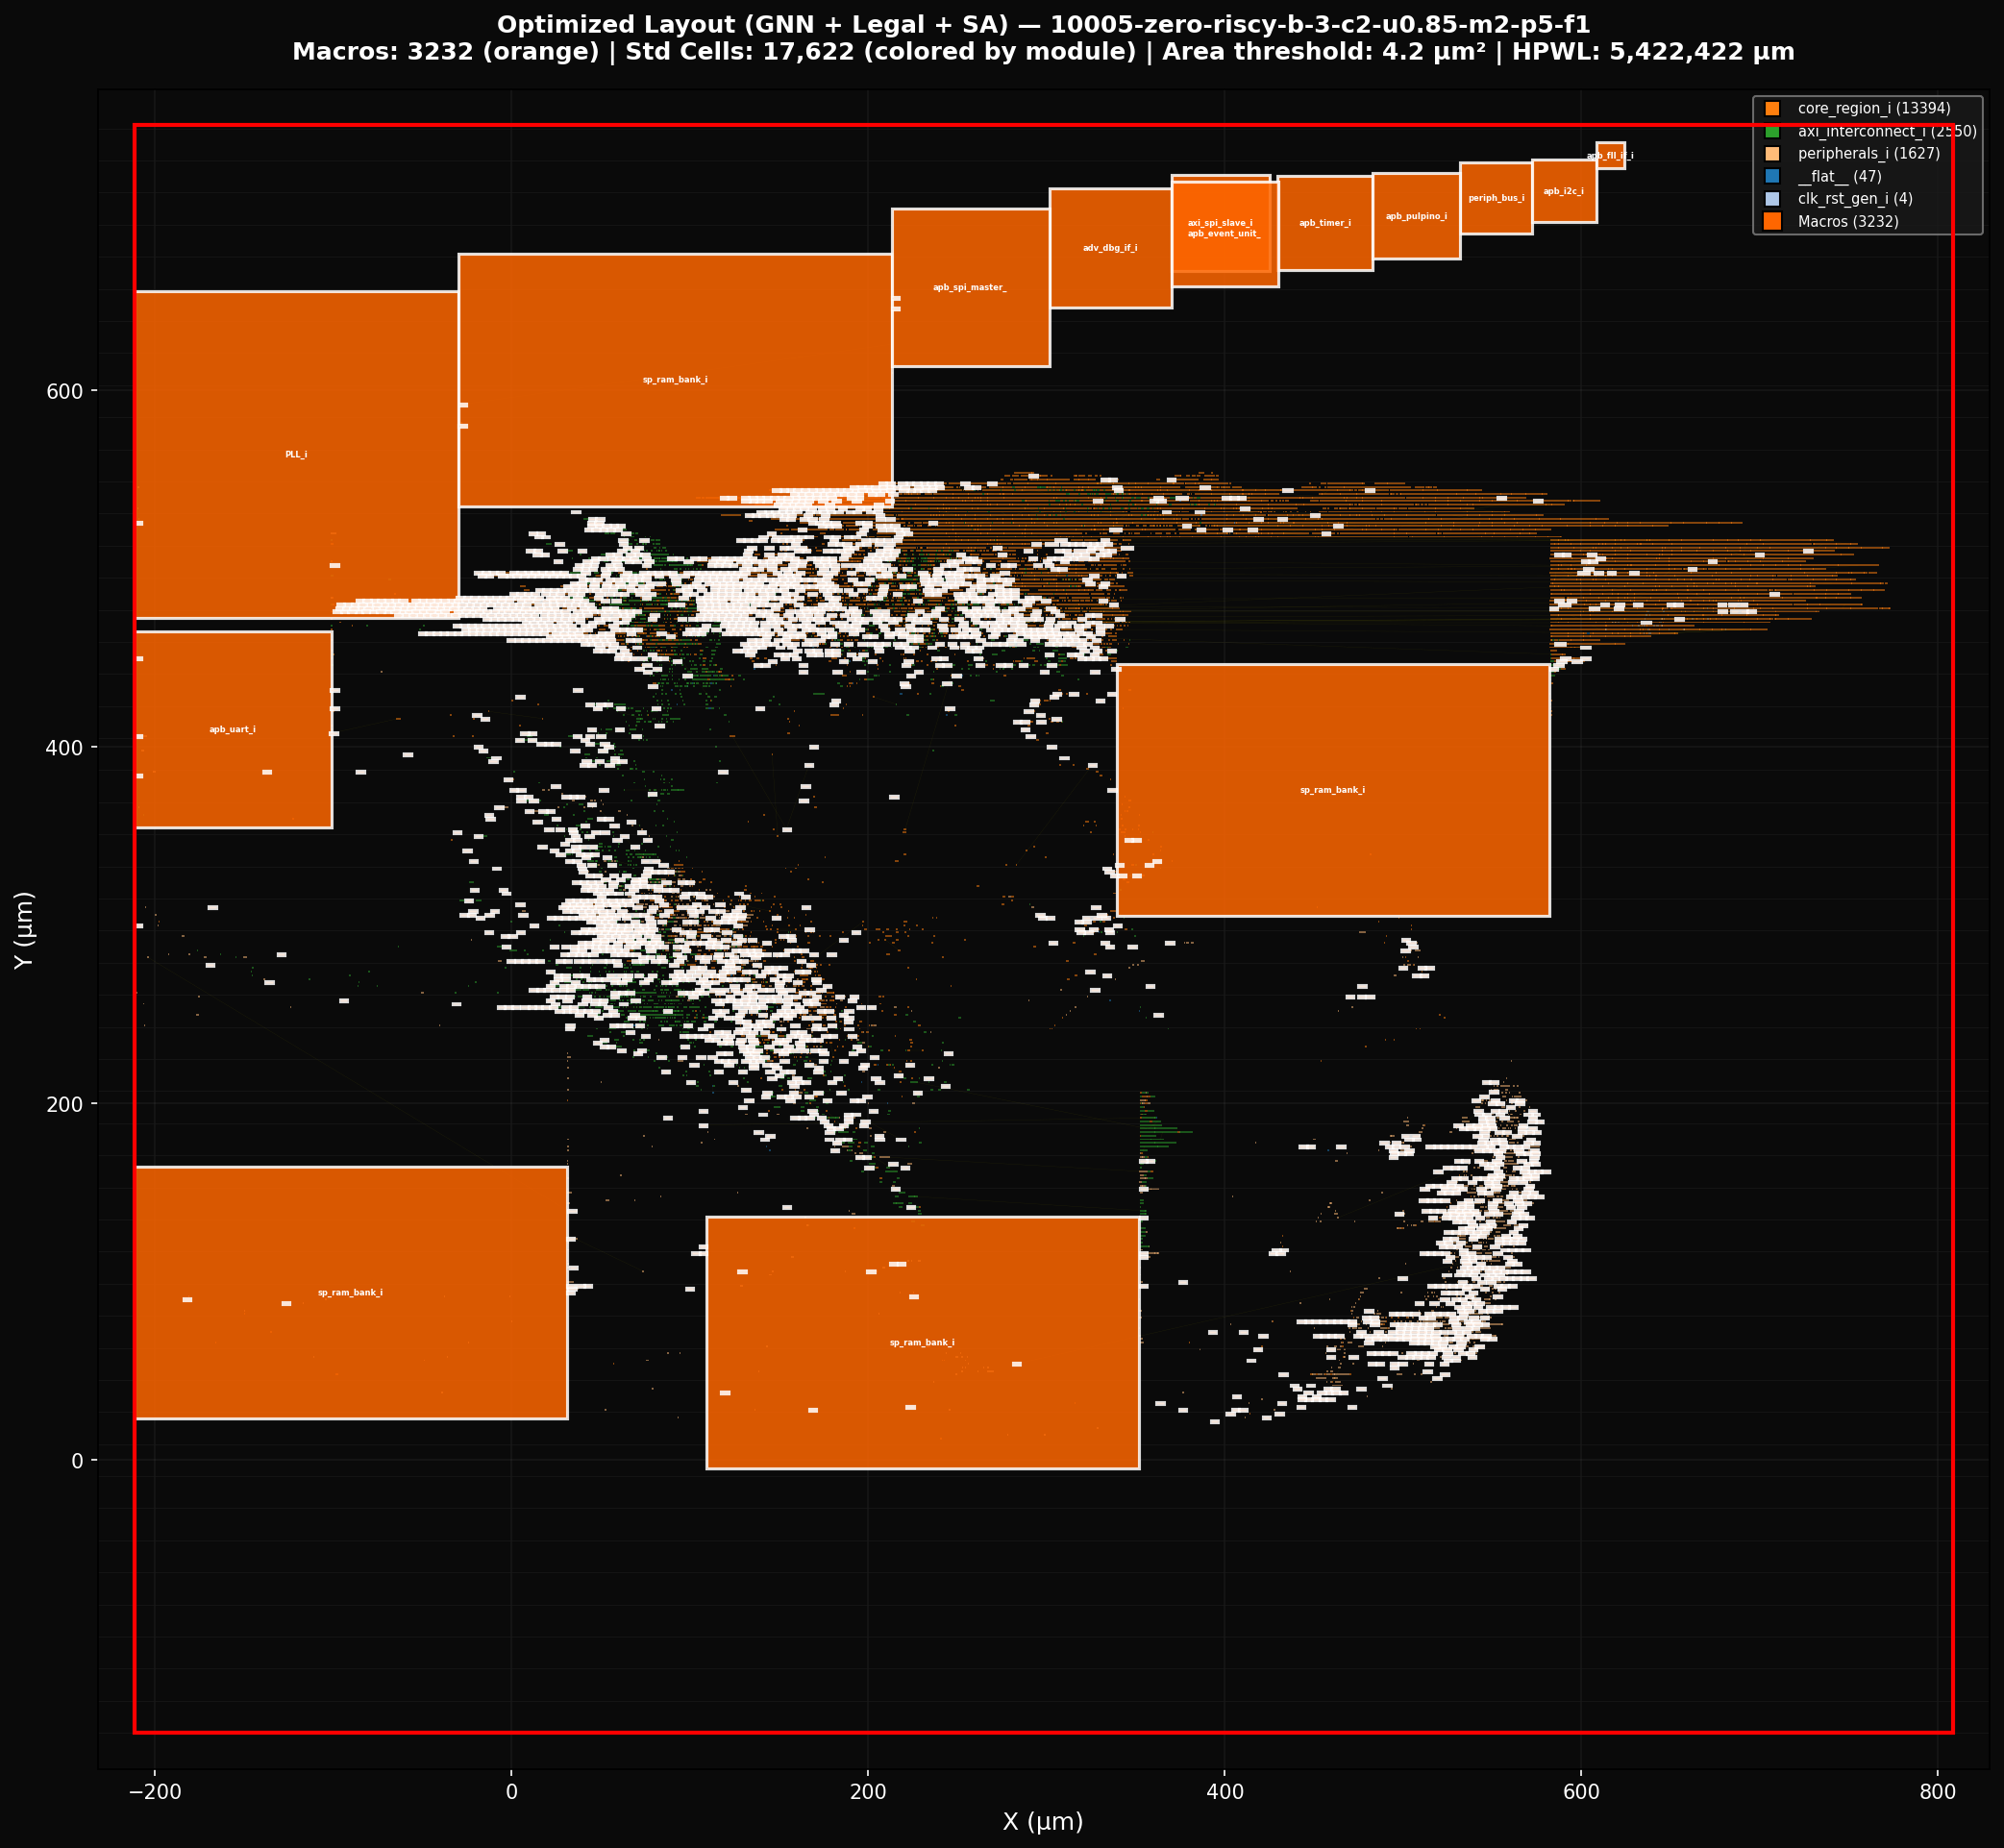


MACRO BLOCKS IDENTIFIED (3232 cells with area ≥ 4.2 µm²)
    1. core_region_i/instr_mem/sp_ram_wrap_i/sp_ram_bank_   242.7 x 141.6 µm  area=   34371.0 µm²  orient=FS  pos=(91.6, 605.9)
    2. core_region_i/data_mem/sp_ram_bank_i                 242.7 x 141.6 µm  area=   34371.0 µm²  orient=FS  pos=(230.6, 65.9)
    3. core_region_i/data_mem_2/sp_ram_bank_i               242.7 x 141.6 µm  area=   34371.0 µm²  orient=FS  pos=(-90.4, 93.9)
    4. core_region_i/data_mem_3/sp_ram_bank_i               242.7 x 141.6 µm  area=   34371.0 µm²  orient=N  pos=(460.8, 375.9)
    5. clk_rst_gen_i/PLL_i                                  181.9 x 183.7 µm  area=   33416.9 µm²  orient=N  pos=(-120.8, 563.9)
    6. peripherals_i/apb_uart_i                             110.5 x 110.2 µm  area=   12178.2 µm²  orient=FS  pos=(-156.5, 409.9)
    7. peripherals_i/apb_spi_master_i                        88.4 x  88.2 µm  area=    7797.8 µm²  orient=FS  pos=(257.3, 657.9)
    8. core_region_i/adv_dbg_if_i         

In [39]:
# ============================================================
# STEP 20: Full Test — Chip Layout with Macros Visualization
# ============================================================

def identify_macros(cell_widths, cell_heights, area_threshold_percentile=95):
    """Identify macro blocks (large cells) vs standard cells.
    
    Macros are cells whose area is above the given percentile.
    Returns boolean mask: True = macro, False = standard cell.
    """
    areas = cell_widths * cell_heights
    threshold = np.percentile(areas, area_threshold_percentile)
    is_macro = areas >= threshold
    return is_macro, areas, threshold


def get_hierarchy_color(cell_name, cmap_dict):
    """Get color for a cell based on its top-level hierarchy module."""
    top_module = cell_name.split('/')[0] if '/' in cell_name else '__flat__'
    if top_module not in cmap_dict:
        # Assign a new color
        n = len(cmap_dict)
        cmap_dict[top_module] = plt.cm.tab20(n % 20)
    return cmap_dict[top_module], top_module


def visualize_chip_with_macros(coords_um, cell_w, cell_h, cell_names, 
                                edge_index, chip_bounds, orientations,
                                title="Chip Layout", hpwl_val=None,
                                save_path=None, macro_pctile=95):
    """Production-quality chip visualization with macro identification.
    
    - Macros drawn as large labeled rectangles
    - Standard cells color-coded by hierarchy
    - Row grid lines
    - Net connections
    - HPWL overlay
    """
    is_macro, areas, area_thresh = identify_macros(cell_w, cell_h, macro_pctile)
    macro_idx = np.where(is_macro)[0]
    std_idx = np.where(~is_macro)[0]
    
    xmin, ymin, xmax, ymax = chip_bounds
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 14), dpi=150)
    ax.set_facecolor('#0a0a0a')
    fig.patch.set_facecolor('#0a0a0a')
    
    # ---- Draw row grid ----
    row_ys = np.arange(ymin, ymax, ROW_HEIGHT_UM)
    for ry in row_ys[::max(1, len(row_ys)//50)]:  # sample to avoid clutter
        ax.axhline(y=ry, color='#1a1a1a', linewidth=0.3)
    
    # ---- Draw standard cells (color by hierarchy) ----
    cmap_dict = {}
    # Group by top-level module for batch drawing
    module_rects = defaultdict(list)
    module_colors = {}
    
    for i in std_idx:
        color, mod = get_hierarchy_color(cell_names[i], cmap_dict)
        x, y = coords_um[i]
        w = max(cell_w[i], 0.5)
        h = max(cell_h[i], 0.5)
        module_rects[mod].append(Rectangle((x - w/2, y - h/2), w, h))
        module_colors[mod] = color
    
    for mod, rects in module_rects.items():
        pc = PatchCollection(rects, facecolor=module_colors[mod], 
                            edgecolor='none', alpha=0.5)
        ax.add_collection(pc)
    
    # ---- Draw macros (large, labeled, prominent) ----
    for i in macro_idx:
        x, y = coords_um[i]
        w = max(cell_w[i], 1.0)
        h = max(cell_h[i], 1.0)
        
        # Macro rectangle with border
        rect = Rectangle((x - w/2, y - h/2), w, h,
                         facecolor='#ff6600', edgecolor='white', 
                         alpha=0.85, linewidth=1.5, zorder=10)
        ax.add_patch(rect)
        
        # Label the macro
        short_name = cell_names[i].split('/')[-1][:15]
        if w > 5 and h > 3:  # only label if big enough to see
            ax.text(x, y, short_name, fontsize=4, color='white',
                   ha='center', va='center', fontweight='bold', zorder=11)
    
    # ---- Draw net connections (sample) ----
    n_edges = min(500, edge_index.shape[1])
    sample_e = np.random.choice(edge_index.shape[1], n_edges, replace=False)
    for ei in sample_e:
        s, d = edge_index[0, ei], edge_index[1, ei]
        ax.plot([coords_um[s, 0], coords_um[d, 0]], 
                [coords_um[s, 1], coords_um[d, 1]],
                color='yellow', alpha=0.08, linewidth=0.2, zorder=5)
    
    # ---- Die boundary ----
    die_rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                         facecolor='none', edgecolor='red', linewidth=2, zorder=15)
    ax.add_patch(die_rect)
    
    # ---- Axis formatting ----
    margin = max(xmax - xmin, ymax - ymin) * 0.02
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)
    ax.set_aspect('equal')
    ax.set_xlabel('X (µm)', fontsize=12, color='white')
    ax.set_ylabel('Y (µm)', fontsize=12, color='white')
    ax.tick_params(colors='white')
    ax.grid(True, alpha=0.1, color='gray')
    
    # ---- Title with metrics ----
    n_macros = len(macro_idx)
    n_std = len(std_idx)
    hpwl_str = f" | HPWL: {hpwl_val:,.0f} µm" if hpwl_val else ""
    ax.set_title(f"{title}\n"
                 f"Macros: {n_macros} (orange) | Std Cells: {n_std:,} (colored by module) | "
                 f"Area threshold: {area_thresh:.1f} µm²{hpwl_str}",
                 fontsize=12, fontweight='bold', color='white', pad=15)
    
    # ---- Legend for top modules ----
    from matplotlib.lines import Line2D
    legend_items = []
    shown_modules = sorted(module_colors.keys(), 
                           key=lambda m: len(module_rects[m]), reverse=True)[:8]
    for mod in shown_modules:
        legend_items.append(Line2D([0], [0], marker='s', color='none',
                                  markerfacecolor=module_colors[mod], markersize=8,
                                  label=f'{mod} ({len(module_rects[mod])})'))
    legend_items.append(Line2D([0], [0], marker='s', color='none',
                              markerfacecolor='#ff6600', markersize=10,
                              label=f'Macros ({n_macros})'))
    ax.legend(handles=legend_items, loc='upper right', fontsize=7,
             facecolor='#1a1a1a', edgecolor='gray', labelcolor='white')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, facecolor='#0a0a0a', bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.show()
    
    # Print macro details
    print(f"\n{'='*60}")
    print(f"MACRO BLOCKS IDENTIFIED ({n_macros} cells with area ≥ {area_thresh:.1f} µm²)")
    print(f"{'='*60}")
    sorted_macros = sorted(macro_idx, key=lambda i: areas[i], reverse=True)
    for rank, i in enumerate(sorted_macros[:20]):
        orient = orientations[i] if orientations else 'N'
        print(f"  {rank+1:3d}. {cell_names[i][:50]:<50s} "
              f"{cell_w[i]:7.1f} x {cell_h[i]:5.1f} µm  "
              f"area={areas[i]:10.1f} µm²  orient={orient}  "
              f"pos=({coords_um[i,0]:.1f}, {coords_um[i,1]:.1f})")
    if n_macros > 20:
        print(f"  ... and {n_macros - 20} more macros")


# ==================================================================
# RUN FULL PIPELINE ON A TEST CASE
# ==================================================================
print("=" * 70)
print("FULL PIPELINE TEST — Single Sample with Macro Visualization")
print("=" * 70)

# Pick a test sample
VIS_IDX = min(2, len(test_data) - 1)
vis_data = test_data[VIS_IDX].to(device)

# ---- 1. GNN Inference (GPU) ----
print("\n[1/4] GNN inference on GPU...")
model.eval()
with torch.no_grad():
    vis_pred = model(vis_data).cpu().numpy()

vis_cb = vis_data.chip_bounds.cpu().numpy()
vis_cw = vis_cb[2] - vis_cb[0]
vis_ch = vis_cb[3] - vis_cb[1]
vis_pred_um = vis_pred * np.array([vis_cw, vis_ch]) + np.array([vis_cb[0], vis_cb[1]])
vis_gt_um   = vis_data.y.cpu().numpy() * np.array([vis_cw, vis_ch]) + np.array([vis_cb[0], vis_cb[1]])
vis_cell_w = vis_data.cell_widths.cpu().numpy()
vis_cell_h = vis_data.cell_heights.cpu().numpy()
vis_ei     = vis_data.edge_index.cpu().numpy()
vis_names  = vis_data.cell_names_list

hpwl_vis_gt  = compute_hpwl_gpu(vis_gt_um, vis_ei)
hpwl_vis_gnn = compute_hpwl_gpu(vis_pred_um, vis_ei)
print(f"   Cells: {vis_data.num_cells:,} | GNN HPWL: {hpwl_vis_gnn:,.0f} µm | GT HPWL: {hpwl_vis_gt:,.0f} µm")

# ---- 2. Legalization ----
print("[2/4] Tetris legalization...")
vis_legalizer = TetrisLegalizer(vis_cb[0], vis_cb[1], vis_cb[2], vis_cb[3])
vis_legal, vis_orient, vis_lstats = vis_legalizer.legalize(vis_pred_um, vis_cell_w, vis_cell_h)
hpwl_vis_legal = compute_hpwl_gpu(vis_legal, vis_ei)
print(f"   HPWL after legalization: {hpwl_vis_legal:,.0f} µm | Displacement: {vis_lstats['avg_displacement']:.1f} µm avg")

# ---- 3. Detailed placement (GPU-accelerated SA) ----
print("[3/4] Detailed placement (SA on GPU)...")
vis_placer = DetailedPlacer(vis_ei, vis_cell_w, vis_cell_h)
vis_final, hpwl_vis_final = vis_placer.simulated_annealing(
    vis_legal, n_iterations=2000, T_start=40.0, T_end=0.1, move_range=3.0
)

# ---- 4. Visualize ----
print("[4/4] Rendering chip layout with macros...\n")

# Ground truth layout
visualize_chip_with_macros(
    vis_gt_um, vis_cell_w, vis_cell_h, vis_names, vis_ei, vis_cb, vis_orient,
    title=f"Ground Truth Layout — {vis_data.sample_name}",
    hpwl_val=hpwl_vis_gt,
    save_path=os.path.join(RESULTS_DIR, f"{vis_data.sample_name}_gt_macros.png"),
    macro_pctile=95
)

# GNN predicted layout
visualize_chip_with_macros(
    vis_pred_um, vis_cell_w, vis_cell_h, vis_names, vis_ei, vis_cb, ['N']*len(vis_pred_um),
    title=f"GNN Predicted Layout — {vis_data.sample_name}",
    hpwl_val=hpwl_vis_gnn,
    save_path=os.path.join(RESULTS_DIR, f"{vis_data.sample_name}_gnn_macros.png"),
    macro_pctile=95
)

# Final optimized layout
visualize_chip_with_macros(
    vis_final, vis_cell_w, vis_cell_h, vis_names, vis_ei, vis_cb, vis_orient,
    title=f"Optimized Layout (GNN + Legal + SA) — {vis_data.sample_name}",
    hpwl_val=hpwl_vis_final,
    save_path=os.path.join(RESULTS_DIR, f"{vis_data.sample_name}_optimized_macros.png"),
    macro_pctile=95
)

# Final summary
print(f"\n{'='*60}")
print(f"TEST CASE SUMMARY: {vis_data.sample_name}")
print(f"{'='*60}")
print(f"{'Stage':<30} {'HPWL (µm)':>15} {'vs GT':>10}")
print(f"{'-'*55}")
print(f"{'Ground Truth':<30} {hpwl_vis_gt:>15,.0f} {'1.00x':>10}")
print(f"{'GNN Global':<30} {hpwl_vis_gnn:>15,.0f} {hpwl_vis_gnn/hpwl_vis_gt:>9.2f}x")
print(f"{'After Legalization':<30} {hpwl_vis_legal:>15,.0f} {hpwl_vis_legal/hpwl_vis_gt:>9.2f}x")
print(f"{'After SA Optimization':<30} {hpwl_vis_final:>15,.0f} {hpwl_vis_final/hpwl_vis_gt:>9.2f}x")
print(f"{'-'*55}")
improvement = (1 - hpwl_vis_final / hpwl_vis_gnn) * 100
print(f"Total improvement from raw GNN: {improvement:.1f}%")
print(f"{'='*60}")